In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from netCDF4 import Dataset as ncdf
import numpy as np
from datetime import datetime,timedelta
import glob
import shutil
from os import path
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mmctools.helper_functions import get_nc_file_times, power_spectral_density, calc_spectra
from scipy.stats import pearsonr
from string import ascii_lowercase
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [3]:
sst_data_dict = {
    
      'CMC' : {
              'lat_name' : 'lat',
              'lon_name' : 'lon',
              'sst_name' : 'analysed_sst',
              'time_dim' : 'time',
          'decode_times' : True , 
                 'color' : 'c',
                  'grid' : '0.1˚',
            'components' : '7 satellite sensors, drifting/moored buoys ',
                'marker' : '^'          
      },
    
    'OSTIA' : {
              'lat_name' : 'lat',
              'lon_name' : 'lon',
              'sst_name' : 'analysed_sst',
              'time_dim' : 'time',
          'decode_times' : False, 
                 'color' : 'orange',
                  'grid' : '0.054˚',
            'components' : '7 satellite sensors, drifting/moored buoys',
                'marker' : '$\clubsuit$'
      },
    
     'NCEI' : {
              'lat_name' : 'lat',
              'lon_name' : 'lon',
              'sst_name' : 'analysed_sst',
              'time_dim' : 'time',
          'decode_times' : True , 
                 'color' : 'peru',
                  'grid' : '0.25˚',
            'components' : '7 satellite sensors, ships, drifting/moored buoys',
                'marker' : 'p'
      },
    
     'NAVO' : {
              'lat_name' : 'lat',
              'lon_name' : 'lon',
              'sst_name' : 'analysed_sst',
              'time_dim' : 'time',
          'decode_times' : True , 
                 'color' : 'm',
                  'grid' : '0.1˚',
            'components' : '5 satellite sensors',
                'marker' : 'X'
      },
    
      'MUR' : {
              'lat_name' : 'lat',
              'lon_name' : 'lon',
              'sst_name' : 'analysed_sst',
              'time_dim' : 'time',
          'decode_times' : True , 
                 'color' : 'r',
                  'grid' : '0.01˚',
            'components' : '6 satellite sensors, drifting/moored buoys',
                'marker' : '$\spadesuit$'
      },
    
    'MODIS' : {
              'lat_name' : 'latitude',
              'lon_name' : 'longitude',
              'sst_name' : 'sst_data',
              'time_dim' : 'time',
          'decode_times' : True , 
                 'color' : 'b',
                  'grid' : '4.625 km',
            'components' : '2 satellite sensors',
                'marker' : '$\u2665$'
      },
    
    'G1SST' : {
              'lat_name' : 'lat',
              'lon_name' : 'lon',
              'sst_name' : 'analysed_sst',
              'time_dim' : 'time',
          'decode_times' : False, 
                 'color' : 'g',
                  'grid' : '0.009˚',
            'components' : '8 satellite sensors, drifting/moored buoys',
                'marker' : '$\u2666$'
      },
    
     'OSPO' : {
              'lat_name' : 'lat',
              'lon_name' : 'lon',
              'sst_name' : 'analysed_sst',
              'time_dim' : 'time',
          'decode_times' : False, 
                 'color' : 'lime',
                  'grid' : '0.054˚',
            'components' : '6 satellite sensors, ships, drifting/moored buoys',
                'marker' : 'P'
     },
    
     'ERAI' : {
              'lat_name' : 'lat',
              'lon_name' : 'lon',
              'sst_name' : 'tsk',
              'time_dim' : 'datetime',
          'decode_times' : False, 
                 'color' : 'darkblue',
                  'grid' : '0.054˚',
            'components' : ' ',
                'marker' : 'o',
                   'name':'ERA-I'
      },
    
     'ERA5' : {
              'lat_name' : 'lat',
              'lon_name' : 'lon',
              'sst_name' : 'tsk',
              'time_dim' : 'datetime',
          'decode_times' : False, 
                 'color' : 'darkred',
                  'grid' : '0.054˚',
            'components' : ' ',
                'marker' : '*',
                   'name':'ERA5'

      },
    
     'FNLA' : {
              'lat_name' : 'lat',
              'lon_name' : 'lon',
              'sst_name' : 'tsk',
              'time_dim' : 'datetime',
          'decode_times' : False, 
                 'color' : 'green',
                  'grid' : '0.054˚',
            'components' : ' ',
                'marker' : 's',
                   'name':'FNL'

      },
    
}

In [4]:
sst_dir      = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/SST/'
#sst_datasets = ['CMC', 'OSTIA', 'NCEI', 'NAVO', 'MUR', 'MODIS', 'G1SST', 'OSPO']
sst_datasets = list(sst_data_dict.keys())

wrf_dir = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/'
icbcs = ['ERAI','FNLA','ERA5']
ref_stn = 'IAD'
case_dom = [3,3,3]

for icbc in icbcs:
    sst_datasets.remove(icbc)
# Base directory where everything is stored:
f_dir = '/glade/work/hawbecke/ATEC/Chesapeake/'
# Which reanalysis to use:
reanalysis = 'ERAI'
# Location of met_em files:
met_dir = '{}SENSITIVITY_STUDY/20190716to20190801/met_em/{}/orig/'.format(f_dir,reanalysis)

case_start = '2019-07-16 00:00:00'
case_end   = '2019-08-01 00:00:00'

plt_order = ['G1SST','MUR','MODIS','OSPO','OSTIA','NAVO','CMC','NCEI']

In [5]:
print(r'\begin{table}')
print(r'\begin{center}')
print(r'\caption{\label{table:WSTDataResolution}}')
print(r'\bgroup')
print(r'\def\arraystretch{1.5}')
print(r'\begin{tabular}{|>{\centering}m{0.15\textwidth}|>{\centering}m{0.2\textwidth}|p{0.5\textwidth}|}')
print(r'\hline')
print(r'\textbf{WST Dataset} & \textbf{Spatial Resolution (Lat. and Lon.)} & \textbf{Compiled Sensors} \\')
print(r'\hline')
for sst_data in plt_order:
    if sst_data == 'MODIS':
        #res = '0.04167˚'
        res = '0.042˚ ({})'.format(sst_data_dict[sst_data]['grid'])
    else:
        res = sst_data_dict[sst_data]['grid']
    res = res.replace('˚',r'{\textdegree}')
    #res += ' grid'
    components = sst_data_dict[sst_data]['components']
    line = r'{} & {} & {} \\'.format(sst_data,res,components)
    print(line)
print(r'\hline')
print(r'\end{tabular}')
print(r'\egroup')
print(r'\end{center}')
print(r'\end{table}')

\begin{table}
\begin{center}
\caption{\label{table:WSTDataResolution}}
\bgroup
\def\arraystretch{1.5}
\begin{tabular}{|>{\centering}m{0.15\textwidth}|>{\centering}m{0.2\textwidth}|p{0.5\textwidth}|}
\hline
\textbf{WST Dataset} & \textbf{Spatial Resolution (Lat. and Lon.)} & \textbf{Compiled Sensors} \\
\hline
G1SST & 0.009{\textdegree} & 8 satellite sensors, drifting/moored buoys \\
MUR & 0.01{\textdegree} & 6 satellite sensors, drifting/moored buoys \\
MODIS & 0.042{\textdegree} (4.625 km) & 2 satellite sensors \\
OSPO & 0.054{\textdegree} & 6 satellite sensors, ships, drifting/moored buoys \\
OSTIA & 0.054{\textdegree} & 7 satellite sensors, drifting/moored buoys \\
NAVO & 0.1{\textdegree} & 5 satellite sensors \\
CMC & 0.1{\textdegree} & 7 satellite sensors, drifting/moored buoys  \\
NCEI & 0.25{\textdegree} & 7 satellite sensors, ships, drifting/moored buoys \\
\hline
\end{tabular}
\egroup
\end{center}
\end{table}


In [6]:
save_dir = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/img/'
save_figs = False

# Functions needed:

In [7]:
def convert_latlon_xy(lat):
    '''
    Given a latitude, this returns meters per degree latitude and meters per degree longitude.
    Formulation found at: https://en.wikipedia.org/wiki/Geographic_coordinate_system#Expressing_latitude_and_longitude_as_linear_units
    '''
    lat_rad = np.deg2rad(lat)
    m_per_deglat = 111132.92 - 559.82*np.cos(2*lat_rad) + 1.175*np.cos(4*lat_rad) - 0.0023*np.cos(6*lat_rad)
    m_per_deglon = 111412.84*np.cos(lat_rad) - 93.5*np.cos(3*lat_rad) + 0.118*np.cos(5*lat_rad)
    return(m_per_deglat,m_per_deglon)

def get_psd(da):
    da.name = 'sst'
    df = da.to_dataframe()

    df = df.fillna(method='ffill').fillna(method='bfill').sort_index()

    avg_dx = np.mean(df.index[1:] - df.index[:-1])
    clean_index = np.linspace(df.index[0],df.index[-1],len(df))
    if len(clean_index) != len(df):
        print(clean_index[1:]-clean_index[:-1])
        print(df.index[1:] - df.index[:-1])
    df.index = clean_index
    
    psd = power_spectral_density(df,window_size=len(df),window_type=np.ones(len(df)),detrend=None)
    psd = psd.drop(0.0)
    if np.any(np.isnan(psd)):
        print(df)
        plt.title(latj)
        plt.plot(df,marker='o')
        plt.show()
        wefwef

    return(psd)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def KelvintoFahrenheit(T):
    return((9.0/5.0)*(T-273.0) + 32.0)

# Read in Obs:

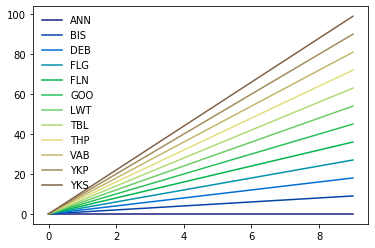

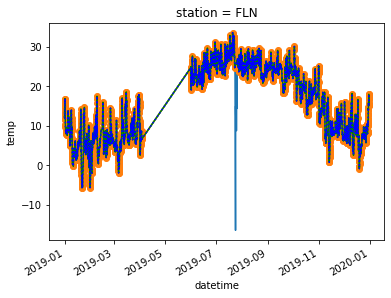

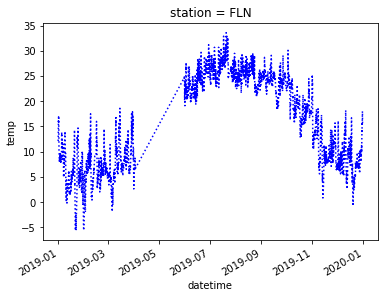

In [8]:
obs_f_dir = '/glade/work/hawbecke/ATEC/Chesapeake/Data/Obs/BUOY/'
obs_type = 'combined' # combined or CBIBS or NDBC
#obs_dir = '{}{}/'.format(obs_f_dir,obs_type)
buoy_f = '{}{}_buoy_data_res_2019.nc'.format(obs_f_dir,obs_type)
buoy_ds = xr.open_dataset(buoy_f)

buoy_list = list(buoy_ds.station.data)

bad_buoys = ['PMC','GRF','SRP','WDC','CAM','SLM','JTN']

for bad_buoy in bad_buoys:
    if bad_buoy in buoy_list: buoy_list.remove(bad_buoy)
    
buoy_loc_dict = {}
for stn in buoy_list:
    buoy_loc_dict[stn] = {'lat':float(buoy_ds.sel(station=stn).lat.data),
                          'lon':float(buoy_ds.sel(station=stn).lon.data)}

#buoy_loc_dict['JTN']['lat'] = 37.21137
#buoy_loc_dict['JTN']['lon'] = -76.78677


buoy_colors = {}
for bb,buoyn in enumerate(buoy_list):
    line_cols = plt.cm.terrain(np.linspace(0.0,0.7,len(buoy_list)))[bb]
    darken = 0.1
    for tt,col in enumerate(line_cols):
        if tt < 3:
            line_cols[tt] = col - darken
            if line_cols[tt] < 0.0: line_cols[tt] = 0.0
    buoy_colors[buoyn] = line_cols
for bb,buoyn in enumerate(buoy_list):
    plt.plot(np.arange(0,10),np.arange(0,10)*bb,c=buoy_colors[buoyn],label=buoyn)
plt.legend(frameon=False)
plt.show()

if 'FLN' in buoy_ds.station.data:
    temp_obs = buoy_ds.temp.copy()
    buoy_ds = buoy_ds.drop_vars('temp')

    fln = temp_obs.sel(station='FLN')
    t_s = buoy_ds.datetime[0]
    t_e = buoy_ds.datetime[-1]
    fln.sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot()

    rem_starts = ['2019-07-23 18:00:00','2019-07-27 00:00:00']
    rem_ends  = ['2019-07-26 12:00:00','2019-07-27 01:45:00']

    #rem_starts = ['2019-07-23 18:00:00']
    #rem_ends = ['2019-07-27 01:45:00']
    for rem_s,rem_e in zip(rem_starts,rem_ends):
        fln.sel(datetime=slice(rem_s,rem_e)).data[:] = fln.sel(datetime=slice(rem_s,rem_e)).data[:]*np.nan


    fln.sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot(marker='o')

    temp_obs.sel(station='FLN').data = fln.data
    
    temp_obs.sel(station='FLN').sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot(c='g')
    buoy_ds['temp'] = temp_obs

    buoy_ds.sel(station='FLN').sel(datetime=slice(t_s,t_e)).temp.dropna(how='all',dim='datetime').plot(c='b',ls=':')
    plt.show()
    buoy_ds.sel(station='FLN').sel(datetime=slice(t_s,t_e)).temp.dropna(how='all',dim='datetime').plot(c='b',ls=':')


In [9]:
obs_dir = '/glade/work/hawbecke/ATEC/Chesapeake/Data/Obs/'
awos_ds = xr.open_dataset('{}AWOS/AWOS_2019to2020.nc'.format(obs_dir))
asos_ds = xr.open_dataset('{}ASOS/ASOS_2019to2020.nc'.format(obs_dir))

# Add APG data into AWOS
apg_ds  = xr.open_dataset('{}APG/APG_data_2019.nc'.format(obs_dir))
apg_stn_list = list(apg_ds.station.data)
for ss,apg_stn in enumerate(apg_stn_list):
    if apg_stn == 'PAA':
        apg_stn_list[ss] = 'APG'
apg_ds = apg_ds.assign_coords({'station': apg_stn_list})
non_apg_list = apg_stn_list.copy()
non_apg_list.remove('APG')
apg_ds = apg_ds.drop_sel(station=non_apg_list)
apg_ds = apg_ds.drop(['rh','gust','radt','rain','alt'])

temp = awos_ds.sel(station='APG').combine_first(apg_ds)
temp = temp.squeeze()
temp = temp.expand_dims('station')

lat_da = xr.DataArray([float(apg_ds.lat)], dims=('station'))
lon_da = xr.DataArray([float(apg_ds.lon)], dims=('station'))

temp = temp.assign_coords({'lat':lat_da})
temp = temp.assign_coords({'lon':lon_da})

awos_ds = awos_ds.drop_sel(station=['APG'])

awos_ds = xr.merge([awos_ds,temp])

near_shore_stations = ['APG', 'BWI', 'MTN', 'NAK', 'NHK', 'NUI']
inland_station      = ['IAD']

vars_to_compare = {'wspd':'wspd10',
                   'wdir':'wdir10',
                   'temp':'t2'}

for ss,stn in enumerate(near_shore_stations):
    if stn in asos_ds.get_index('station'):
        stn_ds = asos_ds.sel(station=stn)
    elif stn in awos_ds.get_index('station'):
        stn_ds = awos_ds.sel(station=stn)
    #elif stn in apg_ds.get_index('station'):
    #    stn_ds = apg_ds.sel(station=stn)
    else:
        print('no obs for this station: {}'.format(stn))
    if stn == 'APG':
        stn_ds = apg_ds.sel(station='APG')
        stn_ds.station.data = 'APG'

    obs_res = stn_ds.copy().sel(datetime=slice(t_s,t_e))
    for dd in obs_res.data_vars:
        if dd not in vars_to_compare:
            obs_res = obs_res.drop_vars(dd)
    obs_res = obs_res.resample(datetime='5min').nearest(tolerance='5min')
    if ss == 0:
        obs_res_full = obs_res
    else:
        obs_res_full = xr.concat([obs_res_full,obs_res],dim='station')


deep_buoys = ['DEB','VAB']
shallow_buoys = buoy_list.copy()

for buoy in deep_buoys:
    shallow_buoys.remove(buoy)


# Plot stations and buoys:

In [10]:
onshore_min_max_path = '{}onshore_min_max_new.nc'.format(wrf_dir)
if path.exists(onshore_min_max_path):
    print('loading in onshore min/max dataset!')
    wrf_onshore_min_max_ds = xr.open_dataset(onshore_min_max_path)
    wrf_onshore_min = wrf_onshore_min_max_ds.onshore_min
    wrf_onshore_max = wrf_onshore_min_max_ds.onshore_max
else:
    print('Run BayBreezeDetectionModel.ipynb')

loading in onshore min/max dataset!


In [11]:
lon = wrf_onshore_min_max_ds.XLONG
lat = wrf_onshore_min_max_ds.XLAT
station_dict = {}
for ss,stn in enumerate(near_shore_stations):
    #if stn == 'APG':
    #    stn_ds = apg_ds.sel(station=stn)
    if stn in awos_ds.station:
        stn_ds = awos_ds.sel(station=stn)
    elif stn in asos_ds.station:
        stn_ds = asos_ds.sel(station=stn)
    stn_lat = stn_ds.lat.data
    stn_lon = stn_ds.lon.data
    dist_from_stn = ((lon-stn_lon)**2 + (lat-stn_lat)**2)**0.5
    stn_j,stn_i = np.where(dist_from_stn == np.nanmin(dist_from_stn))
    stn_j = int(stn_j)
    stn_i = int(stn_i)
    if stn == 'NHK': print('{},{}'.format(stn_i,stn_j))
    print('Station: {}'.format(stn))
    print('\tOnshore min - Old: {0:4.3f}\tNew: {1:4.3f}'.format(stn_ds.onshore_min.data,wrf_onshore_min.data[stn_j,stn_i]))
    print('\tOnshore max - Old: {0:4.3f}\tNew: {1:4.3f}'.format(stn_ds.onshore_max.data,wrf_onshore_max.data[stn_j,stn_i]))
    station_dict[stn] = {}
    station_dict[stn]['min'] = wrf_onshore_min.data[stn_j,stn_i]
    station_dict[stn]['max'] = wrf_onshore_max.data[stn_j,stn_i]
    station_dict[stn]['lat'] = stn_lat
    station_dict[stn]['lon'] = stn_lon
    


Station: APG
	Onshore min - Old: 50.000	New: 104.086
	Onshore max - Old: 200.000	New: 200.313
Station: BWI
	Onshore min - Old: 60.000	New: 62.050
	Onshore max - Old: 160.000	New: 162.680
Station: MTN
	Onshore min - Old: 70.000	New: 80.538
	Onshore max - Old: 190.000	New: 182.490
Station: NAK
	Onshore min - Old: 20.000	New: 29.745
	Onshore max - Old: 190.000	New: 194.036
104,85
Station: NHK
	Onshore min - Old: -10.000	New: -0.000
	Onshore max - Old: 170.000	New: 194.800
Station: NUI
	Onshore min - Old: 0.000	New: 1.700
	Onshore max - Old: 150.000	New: 215.916


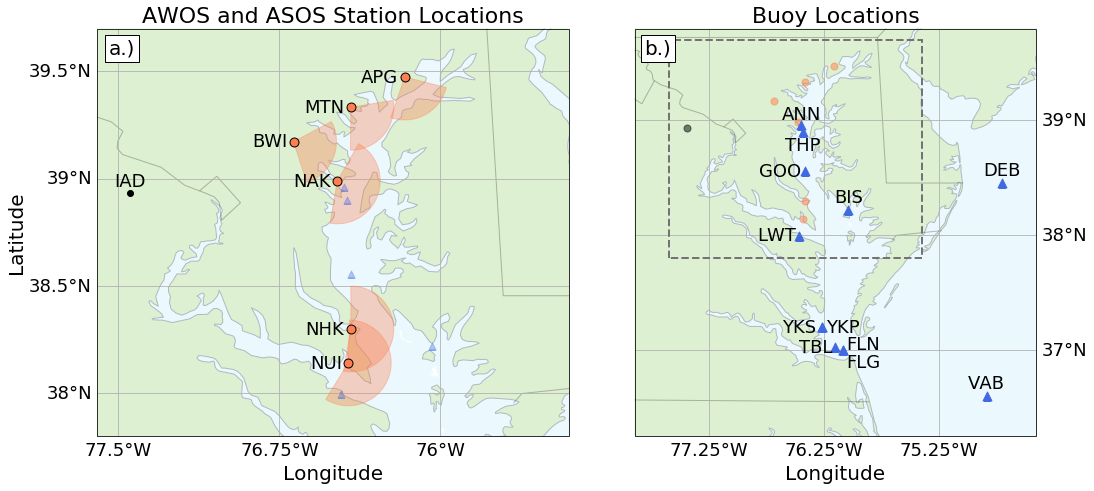

In [12]:
resolution = '10m'
fig, ax = plt.subplots(1, 2, figsize=(18, 7.5), subplot_kw={'projection': ccrs.PlateCarree()})


land = cfeature.NaturalEarthFeature('physical', 'land', resolution,
                                    edgecolor='face',
                                    facecolor="#ddf0d1")

water = cfeature.NaturalEarthFeature('physical', 'ocean', resolution,
                                    edgecolor='face',
                                    facecolor="#ebf9ff")

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

def colorize_state(geometry):
    facecolor = (0.9375, 0.9375, 0.859375)
    return {'facecolor': 'None', 'edgecolor': 'black', 'alpha':0.25}

for axi in range(len(ax)):
    ax[axi].add_feature(land)
    ax[axi].add_feature(water)
    ax[axi].add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax[axi].add_feature(states_provinces, edgecolor='gray',styler=colorize_state)
    ax[axi].coastlines(resolution,alpha=0.25)
    

center_lat = 38.7
center_lon = -76.4
map_1 = [center_lon-1.2, center_lon+1.0, center_lat-0.9, center_lat+1.0]
center_lat = 38.5
map_2 = [center_lon-1.5, center_lon+2.0, center_lat-2.25, center_lat+1.30]

ax[0].set_extent(map_1, ccrs.PlateCarree())
ax[1].set_extent(map_2, ccrs.PlateCarree())


gl = {0:ax[0].gridlines(draw_labels=True,
                        xlocs=np.arange(-78.25,-60,0.75),
                        ylocs=np.arange(37,41,0.5),
                       ),
      1:ax[1].gridlines(draw_labels=True,
                        xlocs=np.arange(-78.25,-60,1.0),
                        ylocs=np.arange(33,41,1.0),
                       )
     }
gl[0].ylabels_right = False
gl[1].ylabels_right = True
gl[1].ylabels_left = False

for axi in range(len(ax)):
    gl[axi].xlabel_style = {'size': 18, 'color': 'k'}
    gl[axi].xformatter = LONGITUDE_FORMATTER
    gl[axi].yformatter = LATITUDE_FORMATTER
    gl[axi].xlabels_top = False
    gl[axi].ylabel_style = {'size': 18, 'color': 'k'}
    
box_x = [map_1[0],map_1[0],map_1[1],map_1[1],map_1[0]]
box_y = [map_1[2],map_1[3],map_1[3],map_1[2],map_1[2]]  
ax[1].fill(box_x,box_y,zorder=2,facecolor='None',lw=2.0,edgecolor='#737373',ls='--')


# Station Labels:
for stn in station_dict:
    x, y = station_dict[stn]['lon'], station_dict[stn]['lat']
    ax[0].scatter(x,y,zorder=3,facecolor='coral',marker='o',s=80,edgecolor='k')
    ax[0].text(x-0.03,y,stn,size=18,ha='right',va='center',zorder=3)
    pts  = np.arange(station_dict[stn]['min'],station_dict[stn]['max'],5.0)
    npts = pts.size
    fill_x = [x]
    fill_y = [y]
    for dd,wdir in enumerate(pts):
        d = 270.0 - wdir    # Convert met degrees to polar
        plt_dist = -0.20 # Met degrees are FROM dir... need negative distance!
        fill_x.append(x+plt_dist*np.cos(np.radians(d)))
        fill_y.append(y+plt_dist*np.sin(np.radians(d)))

    ax[0].fill(fill_x, fill_y,alpha=0.35,lw=None,color='coral',zorder=2)
    x, y = station_dict[stn]['lon'], station_dict[stn]['lat']
    ax[1].scatter(x,y,zorder=3,facecolor='coral',alpha=0.5,marker='o',s=50,lw=None,edgecolor=None)
    
x, y = float(awos_ds.sel(station='IAD').lon.data), float(awos_ds.sel(station='IAD').lat.data)
ax[0].scatter(x,y,zorder=3,c='k')
ax[0].text(x,y+0.01,'IAD',size=18,ha='center',va='bottom',zorder=3)


# Buoy Labels:
buoys_to_plot = list(buoy_ds.station.data)

buoy_c = 'royalblue'
for bad_buoy in bad_buoys:
    buoys_to_plot.remove(bad_buoy)
for stn in buoys_to_plot:
    buoy_lon = float(buoy_ds.sel(station=stn).lon.data)
    buoy_lat = float(buoy_ds.sel(station=stn).lat.data)
    if stn == 'JTN':
        buoy_lat, buoy_lon = 37.21137, -76.78677
    x, y = buoy_lon, buoy_lat
    ax[1].scatter(x,y,zorder=3,c=buoy_c,marker='^',s=80)
    xa,ya = 0.0,0.0
    if stn == 'ANN':
        ha,va = 'center','bottom'
        xa,ya = 0.0,0.01
    elif stn == 'THP':
        ha,va = 'center','top'
        xa,ya = 0.0,-0.04
    elif stn == 'GOO':
        ha,va = 'right','center'
        xa,ya = -0.03,0.0
    elif stn == 'GRF':
        ha,va = 'left','center'
        xa,ya = 0.03,0.0
    elif stn == 'JTN':
        ha,va = 'center','bottom'
        xa,ya = 0.0,0.0
    elif stn == 'LWT':
        ha,va = 'right','center'
        xa,ya = -0.03,0.0
    elif stn == 'YKS':
        ha,va = 'right','center'
        xa,ya = -0.05,0.0
    elif stn == 'YKP':
        ha,va = 'left','center'
        xa,ya = 0.03,0.0
    elif stn == 'TBL':
        ha,va = 'right','center'
        xa,ya = -0.03,0.0
    elif stn == 'FLN':
        ha,va = 'left','bottom'
        xa,ya = 0.03,-0.03
    elif stn == 'FLG':
        ha,va = 'left','top'
        xa,ya = 0.03,-0.03
    else:
        ha,va = 'center','bottom'
        xa,ya = 0.0,0.03
    ax[1].text(x+xa,y+ya,stn,size=18,ha=ha,va=va,zorder=3)
    x, y = buoy_lon, buoy_lat
    ax[0].scatter(x,y,zorder=3,facecolor=buoy_c,alpha=0.35,marker='^',s=50,edgecolor=None)
x, y = float(awos_ds.sel(station='IAD').lon.data), float(awos_ds.sel(station='IAD').lat.data)
ax[1].scatter(x,y,zorder=3,facecolor='k',alpha=0.5,marker='o',s=50,lw=None,edgecolor=None)


ax[0].set_title('AWOS and ASOS Station Locations',size=22)
ax[1].set_title('Buoy Locations',size=22)

props = dict(facecolor='w', alpha=1.0)

# place a text box in upper left in axes coords
map1_width  = map_1[1] - map_1[0]
map1_height = map_1[3] - map_1[2]

map2_width  = map_2[1] - map_2[0]
map2_height = map_2[3] - map_2[2]

txt_loc1 = map_1[0]+0.025*map1_width, map_1[3]-0.025*map1_height
txt_loc2 = map_2[0]+0.025*map2_width, map_2[3]-0.025*map2_height
ax[0].text(txt_loc1[0],txt_loc1[1], 'a.)', bbox=props, ha='left',va='top',fontsize=20)
ax[1].text(txt_loc2[0],txt_loc2[1], 'b.)', bbox=props, ha='left',va='top',fontsize=20)
ax[0].text(0.50,-0.07,'Longitude',size=20,transform=ax[0].transAxes,ha='center',va='top')
ax[1].text(0.50,-0.07,'Longitude',size=20,transform=ax[1].transAxes,ha='center',va='top')
ax[0].text(-0.150,0.5,'Latitude',size=20,transform=ax[0].transAxes,ha='right',va='center',rotation=90)

plt.subplots_adjust(wspace=0.001,hspace=0.001)
figname = '{}StationLocation'.format(save_dir)

if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()

# Find closest buoy to each station:

In [13]:
# Closest Buoys to each Station:
closest_buoy_dict = {}
for ss,stn in enumerate(near_shore_stations):
    station = obs_res_full.sel(station=stn)
    stn_lat = float(station.lat)
    stn_lon = float(station.lon)

    closest_dist = 999.0
    for bb,buoy in enumerate(shallow_buoys):
        buoy_lat = float(buoy_ds.sel(station=buoy).lat)
        buoy_lon = float(buoy_ds.sel(station=buoy).lon)
        buoy_dist = np.sqrt((buoy_lat - stn_lat)**2 + (buoy_lon - stn_lon)**2)

        if buoy_dist < closest_dist:
            closest_dist = buoy_dist
            closest_buoy = buoy
    closest_buoy_dict[stn] = closest_buoy


## Get WRF Footprint:

In [14]:
wrf_files = sorted(glob.glob('{}met_em*'.format(met_dir)))
wrf = np.squeeze(xr.open_dataset(wrf_files[0]))
wrf_lat = wrf.XLAT_M
wrf_lon = wrf.XLONG_M
wrf_landmask = wrf.LANDMASK
wrf_sst = wrf.SST

wrf_footprint = wrf_lat.copy()
wrf_footprint[1:-1,1:-1] = 0.0
wrf_footprint /= wrf_footprint
wrf_footprint = wrf_footprint.fillna(0.0)

for wrff in wrf_files:
    if '2019-07-16_00:00:00' in wrff:
        wrf_d03_met = xr.open_dataset(wrff).squeeze()
        
wrf_d03_lon = wrf_d03_met.XLONG_M
wrf_d03_lat = wrf_d03_met.XLAT_M
wrf_d03_landmask = wrf_d03_met.LANDMASK
wrf_d03_sst = wrf_d03_met.SST


# SST Data:

In [15]:
#subset_width = 10
#subset_bot = 30.0
#subset_lft = -75
subset_width = 15
subset_bot = 25.0
subset_lft = -74.1
subset_top = subset_bot + subset_width
subset_rgt = subset_lft + subset_width

show_fig = False
if show_fig:
    sst_data = 'MUR'
    sst_times = get_nc_file_times(f_dir='{}{}/'.format(sst_dir,sst_data),
                                  f_grep_str='*.nc',
                                  decode_times=sst_data_dict[sst_data]['decode_times'],
                                  time_dim='time',
                                  get_time_from_fname=False,
                                  f_split=['.'],
                                  time_pos=[1])
    sst_nc = xr.open_dataset(sst_times[list(sst_times.keys())[0]],decode_times=sst_data_dict[sst_data]['decode_times'])

    fig,ax = plt.subplots(figsize=(10,4.5))
    ax.set_aspect('equal')
    sst_plt = plt.pcolormesh(sst_nc.lon.data,sst_nc.lat.data,sst_nc.analysed_sst.data[0,:,:],rasterized=True)
    cbar = plt.colorbar(sst_plt,fraction=0.1,pad=0.03,aspect=13.0)
    cbar.ax.tick_params(labelsize=14)
    ax.plot([subset_lft,subset_lft,subset_rgt,subset_rgt,subset_lft],
            [subset_bot,subset_top,subset_top,subset_bot,subset_bot],
            c='k',alpha=0.5)
    ax.tick_params(labelsize=15)
    ax.set_title('WST Analysis Region',size=18)
    ax.set_ylabel('Latitude',size=16)
    ax.set_xlabel('Longitude',size=16)
    plt.show()

sst_subset_dict = {}
show_plot = True

for sst_data in sst_datasets[:]:
    sst_subset_path = '{}{}SSTsubset.nc'.format(sst_dir,sst_data)
    if path.exists(sst_subset_path):
        print('loading ds...',sst_data)
        sst_subset_dict[sst_data] = xr.open_dataset(sst_subset_path)
    else:
        print(sst_data)
        plot_shown = False
        init_subset = True
        if sst_data == 'MODIS':
            get_time_from_fname = True
        else:
            get_time_from_fname = False
        sst_times = get_nc_file_times(f_dir='{}{}/'.format(sst_dir,sst_data),
                                      f_grep_str='*.nc',
                                      decode_times=sst_data_dict[sst_data]['decode_times'],
                                      time_dim='time',
                                      get_time_from_fname=get_time_from_fname,
                                      f_split=['.'],
                                      time_pos=[1])

        for tt,ftime in enumerate(sst_times):

            if (ftime >= pd.to_datetime(case_start)) & (ftime <= pd.to_datetime(case_end)):
                sst_nc = xr.open_dataset(sst_times[ftime],decode_times=sst_data_dict[sst_data]['decode_times'])
                if not sst_data_dict[sst_data]['decode_times']:
                    nc_times = sst_nc[sst_data_dict[sst_data]['time_dim']].data
                    for ff,nc_time in enumerate(nc_times):
                        time_start = pd.to_datetime(sst_nc[sst_data_dict[sst_data]['time_dim']].units.replace('seconds since ',''))
                        read_time = datetime(time_start.year, time_start.month, time_start.day) + timedelta(seconds=int(nc_time))
                        if read_time == ftime:
                            ftime    = nc_time
                            fmt_time = read_time
                else:      
                    fmt_time = ftime

                if sst_data != 'MODIS':
                    sst_nc = sst_nc.sel({'time':ftime})
                else:
                    sst_nc = np.squeeze(sst_nc)

                sst = sst_nc[sst_data_dict[sst_data]['sst_name']]
                lat = sst[sst_data_dict[sst_data]['lat_name']]
                lon = sst[sst_data_dict[sst_data]['lon_name']]

                if sst_data != 'MODIS':
                    landmask = sst_nc.mask
                    sst = sst.where(landmask==1)

                sst_subset = sst.where(((lat >= subset_bot) & (lat <= subset_top) & (lon >= subset_lft) & (lon <= subset_rgt)))
                if sst_data == 'MODIS':
                    sst_subset = sst_subset.rename({'latitude':'lat','longitude':'lon'})
                sst_subset = sst_subset.dropna(dim='lat',how='all').dropna(dim='lon',how='all')

                if show_plot:
                    if not plot_shown:
                        fig,ax = plt.subplots(figsize=(16,8))
                        sst_plt = ax.pcolormesh(sst_subset.lon,sst_subset.lat,sst_subset)
                        plt.colorbar(sst_plt)
                        ax.contour(wrf_lon,wrf_lat,wrf_footprint,levels=[1.0],colors='k',alpha=0.5)
                        ax.contour(wrf_lon,wrf_lat,wrf_landmask,levels=[1.0],colors='k',alpha=0.5)
                        ax.set_title('{} {}'.format(sst_data,np.shape(sst_subset)),size=22)
                        plt.show()
                        plot_shown = True



                m_per_lat,m_per_lon = convert_latlon_xy(subset_bot + (subset_width/2.0))
                if sst_data == 'MODIS': 
                    m_per_lon = 110986.45
                    m_per_lat = 110996.61
                y = sst_subset.lat*m_per_lat 
                x = sst_subset.lon*m_per_lon
                y = y - np.min(y)
                x = x - np.min(x)
                y.name = 'y'
                x.name = 'x'
                sst_subset['y'] = y
                sst_subset['x'] = x
                sst_subset = sst_subset.drop('time')
                sst_subset['time'] = fmt_time
                sst_subset = sst_subset.expand_dims({'time':1})
                if init_subset:
                    sst_subset_dict[sst_data] = sst_subset
                    init_subset = False
                else:
                    sst_subset_dict[sst_data] = sst_subset.combine_first(sst_subset_dict[sst_data])
                    
        sst_subset_dict[sst_data].to_netcdf(sst_subset_path)
            

loading ds... CMC
loading ds... OSTIA
loading ds... NCEI
loading ds... NAVO
loading ds... MUR
loading ds... MODIS
loading ds... G1SST
loading ds... OSPO


### Calculate Spectra:

In [16]:
show_plots = False
sst_psd_dict = {}


for sst_data in sst_datasets[:]:
    psd_ds_path = '{}{}SSTpsd.nc'.format(sst_dir,sst_data)
    if path.exists(psd_ds_path):
        print('loading ds...',sst_data)
        sst_psd_dict[sst_data] = xr.open_dataset(psd_ds_path)
    else:
        print(sst_data)
        sst_var_name = sst_data_dict[sst_data]['sst_name']
        sst_subset = sst_subset_dict[sst_data]
        for tt,ftime in enumerate(sst_subset.time[:]):
            sst_subset_time = sst_subset.sel({'time':str(ftime.data)})
            sst_subset_time = sst_subset_time.drop('time').swap_dims({'lat':'y','lon':'x'})
            x_dist = sst_subset_time.x.drop('lon')
            y_dist = sst_subset_time.y.drop('lat')

            # N-S Spectra:
            sst_subset_time = sst_subset_time.sortby('y')
            dXs = np.diff(sst_subset_time.y.data)
            dX  = np.nanmean(dXs)
            if not np.allclose(dXs,dX):
                old_y = sst_subset_time.y.data
                mean_dy = np.nanmean(old_y[1:]-old_y[:-1])
                sst_subset_time = sst_subset_time.drop('y')
                sst_subset_time['y'] = np.arange(0,len(old_y))*mean_dy
            psd_daf_NS = calc_spectra(sst_subset_time,var_oi=sst_var_name,
                                      spectra_dim='y',average_dim='x',
                                      window=None,)

            psd_daf_NS['time'] = ftime
            psd_daf_NS = psd_daf_NS.expand_dims({'time':1})
            psd_daf_NS = psd_daf_NS.assign_coords({'time':psd_daf_NS.time})

            # W-E Spectra:
            dXs = np.diff(sst_subset_time.x.data)
            dX  = dXs[0]
            if not np.allclose(dXs,dX):
                old_x = sst_subset_time.x.data
                mean_dx = np.mean(old_x[1:]-old_x[:-1])
                sst_subset_time = sst_subset_time.drop('x')
                sst_subset_time['x'] = np.arange(0,len(old_x))*mean_dx
            psd_daf_WE = calc_spectra(sst_subset_time,var_oi=sst_var_name,
                                      spectra_dim='x',average_dim='y',
                                      window=None,)
            psd_daf_WE['time'] = ftime
            psd_daf_WE = psd_daf_WE.expand_dims({'time':1})
            psd_daf_WE = psd_daf_WE.assign_coords({'time':psd_daf_WE.time})

            if tt == 0:
                psd_NS = psd_daf_NS
                psd_WE = psd_daf_WE
            else:
                psd_NS = psd_NS.combine_first(psd_daf_NS)
                psd_WE = psd_WE.combine_first(psd_daf_WE)
        psd_NS = psd_NS.rename({sst_var_name:'sst_psd_NS','frequency':'frequency_NS'})
        psd_WE = psd_WE.rename({sst_var_name:'sst_psd_WE','frequency':'frequency_WE'})
        psd_WE.rename({})
        psd_ds =  xr.merge([psd_NS,psd_WE])
        psd_ds.to_netcdf(psd_ds_path)
        sst_psd_dict[sst_data] = psd_ds
    

loading ds... CMC
loading ds... OSTIA
loading ds... NCEI
loading ds... NAVO
loading ds... MUR
loading ds... MODIS
loading ds... G1SST
loading ds... OSPO


### Plot averaged spectra:

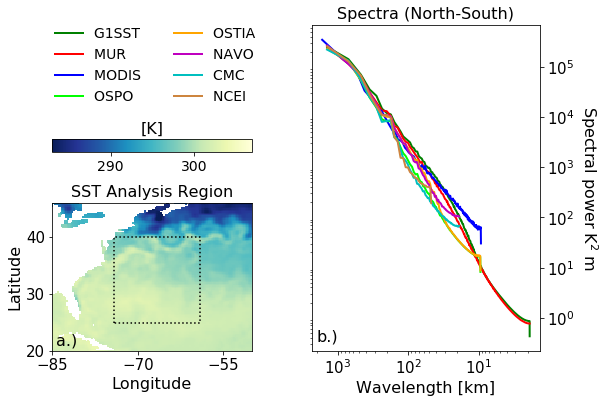

In [17]:
fig = plt.figure(figsize=(9,6))
#specax1 = plt.subplot2grid((2,5),(0,0),rowspan=2,colspan=2)
#specax2 = plt.subplot2grid((2,5),(0,2),rowspan=2,colspan=2,sharey=specax1,sharex=specax1)
#sstax   = plt.subplot2grid((2,5),(1,4),rowspan=1,colspan=1)
#plt.subplots_adjust(wspace=0.3)

specax1 = plt.subplot2grid((2,2),(0,1),rowspan=2,colspan=1)
sstax   = plt.subplot2grid((2,2),(1,0),rowspan=1,colspan=1)

cmap = plt.cm.YlGnBu_r
pmin,pmax = 283,307

for sst_data in plt_order:
    psd_ds = sst_psd_dict[sst_data]
    #NS_avg = psd_ds.sst_psd_NS.mean(dim=('x','time'))
    WE_avg = psd_ds.sst_psd_WE.mean(dim=('y','time'))
    #label_str = '{0:<6} ({1} grid)'.format(sst_data,sst_data_dict[sst_data]['grid'])
    label_str = '{0:<6}'.format(sst_data)
    #specax1.loglog((1/NS_avg.frequency_NS)/1000.0,NS_avg,
    #             label=label_str,
    #             c=sst_data_dict[sst_data]['color'],lw=2.0)
    specax1.loglog((1/WE_avg.frequency_WE)/1000.0,WE_avg,
                 label=label_str,
                 c=sst_data_dict[sst_data]['color'],lw=2.0)

    
specax1.tick_params(labelsize=15)
specax1.set_xlabel('Wavelength [km]',size=16)
#specax1.axvline(4.625*2,ls=':',c='k',alpha=0.5,label='4.625 x 2.0 (Nyquist of MODIS)')
#specax2.tick_params(labelsize=15,labelleft=False)
#specax2.set_xlabel('Wavelength [km]',size=16)
#specax2.axvline(4.625*2,ls=':',c='k',alpha=0.5,label='4.625 x 2.0 (Nyquist of MODIS)')

specax1.invert_xaxis()

specax1.legend(loc=(-1.15,0.74),frameon=False,fontsize=14,ncol=2)

specax1.set_title('Spectra (North-South)',size=16)
specax1.set_ylabel('Spectral power K$^2$ m',size=16,rotation=270,labelpad=25.0)
specax1.yaxis.set_label_position("right")
specax1.tick_params(labelsize=15,left=False,right=True,labelleft=False,labelright=True)
#specax2.set_title('Spectra (West-East)',size=16)

sstax.text(0.02,0.02,'a.)', transform=sstax.transAxes,ha='left',va='bottom',size=16)
specax1.text(0.02,0.02,'b.)', transform=specax1.transAxes,ha='left',va='bottom',size=16)
#specax2.text(0.02,0.02,'b.)', transform=specax2.transAxes,ha='left',va='bottom',size=16)


sst_data = 'NCEI'
if sst_data == 'MODIS':
    get_time_from_fname = True
else:
    get_time_from_fname = False
    
sst_times = get_nc_file_times(f_dir='{}{}/'.format(sst_dir,sst_data),
                              f_grep_str='*.nc',
                              decode_times=sst_data_dict[sst_data]['decode_times'],
                              time_dim='time',
                              get_time_from_fname=get_time_from_fname,
                              f_split=['.'],
                              time_pos=[1])
sst_nc = xr.open_dataset(sst_times[list(sst_times.keys())[0]],decode_times=sst_data_dict[sst_data]['decode_times'])


sstax.set_aspect('equal')
sst_plt = sstax.pcolormesh(sst_nc.lon.data,sst_nc.lat.data,sst_nc.analysed_sst.data[0,:,:],
                          norm=Normalize(pmin,pmax),cmap=cmap,rasterized=True)

cax  = fig.add_axes([0.147,0.585,0.309,0.03])
cbar = plt.colorbar(sst_plt,cax=cax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[K]',size=16)

sstax.plot([subset_lft,subset_lft,subset_rgt,subset_rgt,subset_lft],
        [subset_bot,subset_top,subset_top,subset_bot,subset_bot],
        c='k',alpha=1.0,ls=':')
sstax.tick_params(labelsize=15)
sstax.set_title('SST Analysis Region',size=16)
sstax.set_ylabel('Latitude',size=16)#
#sstax.yaxis.set_label_position("right")
sstax.set_xlabel('Longitude',size=16)
sstax.set_xticks(np.arange(-85,-50,15))
sstax.set_xlim(-85,-50)
sstax.set_ylim(20,46)
if save_figs:
    fig_name = '{}WST_Spectra_1panel'.format(save_dir)
    plt.savefig('{}.png'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

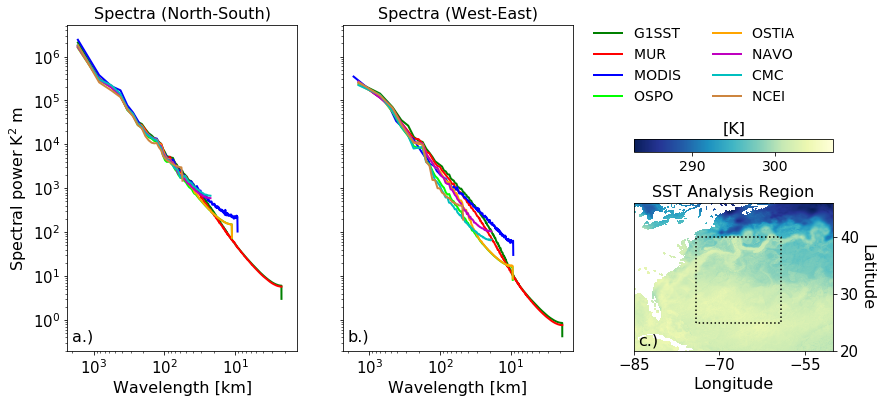

In [18]:
fig = plt.figure(figsize=(14,6))
#specax1 = plt.subplot2grid((2,5),(0,0),rowspan=2,colspan=2)
#specax2 = plt.subplot2grid((2,5),(0,2),rowspan=2,colspan=2,sharey=specax1,sharex=specax1)
#sstax   = plt.subplot2grid((2,5),(1,4),rowspan=1,colspan=1)
#plt.subplots_adjust(wspace=0.3)

specax1 = plt.subplot2grid((2,3),(0,0),rowspan=2,colspan=1)
specax2 = plt.subplot2grid((2,3),(0,1),rowspan=2,colspan=1,sharey=specax1,sharex=specax1)
sstax   = plt.subplot2grid((2,3),(1,2),rowspan=1,colspan=1)

cmap = plt.cm.YlGnBu_r
pmin,pmax = 283,307

for sst_data in plt_order:
    psd_ds = sst_psd_dict[sst_data]
    NS_avg = psd_ds.sst_psd_NS.mean(dim=('x','time'))
    WE_avg = psd_ds.sst_psd_WE.mean(dim=('y','time'))
    #label_str = '{0:<6} ({1} grid)'.format(sst_data,sst_data_dict[sst_data]['grid'])
    label_str = '{0:<6}'.format(sst_data)
    specax1.loglog((1/NS_avg.frequency_NS)/1000.0,NS_avg,
                 label=label_str,
                 c=sst_data_dict[sst_data]['color'],lw=2.0)
    specax2.loglog((1/WE_avg.frequency_WE)/1000.0,WE_avg,
                 label=label_str,
                 c=sst_data_dict[sst_data]['color'],lw=2.0)

    
specax1.tick_params(labelsize=15)
specax1.set_xlabel('Wavelength [km]',size=16)
#specax1.axvline(4.625*2,ls=':',c='k',alpha=0.5,label='4.625 x 2.0 (Nyquist of MODIS)')
specax2.tick_params(labelsize=15,labelleft=False)
specax2.set_xlabel('Wavelength [km]',size=16)
#specax2.axvline(4.625*2,ls=':',c='k',alpha=0.5,label='4.625 x 2.0 (Nyquist of MODIS)')

specax1.invert_xaxis()

specax2.legend(loc=(1.07,0.74),frameon=False,fontsize=14,ncol=2)

specax1.set_title('Spectra (North-South)',size=16)
specax1.set_ylabel('Spectral power K$^2$ m',size=16)
specax2.set_title('Spectra (West-East)',size=16)

specax1.text(0.02,0.02,'a.)', transform=specax1.transAxes,ha='left',va='bottom',size=16)
specax2.text(0.02,0.02,'b.)', transform=specax2.transAxes,ha='left',va='bottom',size=16)
sstax.text(0.02,0.02,'c.)', transform=sstax.transAxes,ha='left',va='bottom',size=16)


sst_data = 'MUR'
if sst_data == 'MODIS':
    get_time_from_fname = True
else:
    get_time_from_fname = False
    
sst_times = get_nc_file_times(f_dir='{}{}/'.format(sst_dir,sst_data),
                              f_grep_str='*.nc',
                              decode_times=sst_data_dict[sst_data]['decode_times'],
                              time_dim='time',
                              get_time_from_fname=get_time_from_fname,
                              f_split=['.'],
                              time_pos=[1])
sst_nc = xr.open_dataset(sst_times[list(sst_times.keys())[0]],decode_times=sst_data_dict[sst_data]['decode_times'])


sstax.set_aspect('equal')
sst_plt = sstax.pcolormesh(sst_nc.lon.data,sst_nc.lat.data,sst_nc.analysed_sst.data[0,:,:],
                          norm=Normalize(pmin,pmax),cmap=cmap,rasterized=True)

cax  = fig.add_axes([0.6875,0.585,0.1975,0.03])
cbar = plt.colorbar(sst_plt,cax=cax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[K]',size=16)

sstax.plot([subset_lft,subset_lft,subset_rgt,subset_rgt,subset_lft],
        [subset_bot,subset_top,subset_top,subset_bot,subset_bot],
        c='k',alpha=1.0,ls=':')
sstax.tick_params(labelsize=15,left=False,right=True,labelleft=False,labelright=True)
sstax.set_title('SST Analysis Region',size=16)
sstax.set_ylabel('Latitude',size=16,rotation=270,labelpad=15.0)
sstax.yaxis.set_label_position("right")
sstax.set_xlabel('Longitude',size=16)
sstax.set_xticks(np.arange(-85,-50,15))
sstax.set_xlim(-85,-50)
sstax.set_ylim(20,46)
if save_figs:
    fig_name = '{}WST_Spectra'.format(save_dir)
    plt.savefig('{}.png'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

# Get WRF met_em data:

In [19]:
case = 'DEFLT_NOFL_NOSK'
dom = 3
case_str = '{}'.format(case)
if dom == 3:
    dt = 9.0
elif dom == 4:
    dt = 3.0
else:
    print('Add logic for domain {}'.format(dom))
print('Starting {} d0{}: time step = {}'.format(case_str,dom,dt))


case_dir = '{}{}/'.format(wrf_dir,case)
twr_path = '{}{}_d0{}_towers.nc'.format(case_dir,case,dom)    
if path.exists(twr_path):
    print('loading in full dataset!')
    wrf_twrs = xr.open_dataset(twr_path)
else:
    wrf_twrs = tsout_seriesReader(case_dir,restarts,wrf_start,'d0{}'.format(dom),structure='unordered',
                                        select_tower=np.append(near_shore_stations,ref_stn),time_step=dt,
                                        #select_tower=near_shore_stations[:2],time_step=dt,
                                        heights=[10.0],height_var='ph')
    wrf_twrs['temp'] = theta_to_T(wrf_twrs[case_str].theta,wrf_twrs[case_str].pr/100.0)-273.15
    wrf_twrs['wspd10'],wrf_twrs[case_str]['wdir10'] = calc_wind(wrf_twrs[case_str],u='u10',v='v10')
    wrf_twrs['t2'] += -273.15 


wrfin_d03 = xr.open_dataset('{}{}/ERAI_20190715/wrfinput_d03'.format(wrf_dir,case)).squeeze()
wrf_d03_landmask = wrfin_d03.LANDMASK
wrf_d03_lat = wrfin_d03.XLAT
wrf_d03_lon = wrfin_d03.XLONG

wrf_dir = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/'
#icbcs = ['ERAI','FNLA','ERA5','OSTIA']
sst_datasets = list(sst_data_dict.keys())
ref_stn = 'IAD'
case_dom = [3]*len(sst_datasets)

sst_dataset = sst_datasets[0]

wrf_stn_dict = {}
wrf_buoy_dict = {}

for cc,sst_dataset in enumerate(sst_datasets):
    if sst_dataset not in ['ERAI','FNLA','ERA5']:
        met_path = '{}met_em/ERAI/{}/raw/'.format(wrf_dir,sst_dataset)
    else:
        met_path = '{}met_em/{}/orig/'.format(wrf_dir,sst_dataset)

    wrf_stn_ds_path = '{}extracted_stations.nc'.format(met_path)
    wrf_buoy_ds_path = '{}extracted_buoys.nc'.format(met_path)
    
    if (path.exists(wrf_stn_ds_path)) and (path.exists(wrf_buoy_ds_path)):
        print('loading ds...',sst_dataset)
        print(wrf_stn_ds_path)
        wrf_stn_dict[sst_dataset] = xr.open_dataset(wrf_stn_ds_path)
        wrf_buoy_dict[sst_dataset] = xr.open_dataset(wrf_buoy_ds_path)
    else:
        print(sst_dataset)
        #ax.set_aspect('equal')
        met_files = sorted(glob.glob('{}met_em.d0{}*'.format(met_path,case_dom[cc])))
        for mm,met_file in enumerate(met_files):
            met = xr.open_dataset(met_file)
            met_time = pd.to_datetime(met.Times.data[0].decode().replace('_',' '))
            if mm == 0:
                met_lon = met.XLONG_M.squeeze()
                met_lat = met.XLAT_M.squeeze()
                met_landmask = met.LANDMASK.squeeze()


            for bb,buoyn in enumerate(shallow_buoys):
                
                loci = int(wrf_twrs.sel(station=buoyn).i.data)
                locj = int(wrf_twrs.sel(station=buoyn).j.data)
                # Some buoy locations are on land... grab the water cell next to it
                stn_landmask = met_landmask.sel(south_north=locj,west_east=loci).data
                if stn_landmask == 1.0:
                    if buoyn == 'JTN':
                        #print(stn_landmask)
                        #print(met_landmask.sel(south_north=slice(locj-1,locj+2),
                        #                       west_east=slice(loci-1,loci+2)).data)
                        locj -= 1
                        loci += 1
                        #print(met.SST.sel(west_east=loci,south_north=locj).data)
                    elif buoyn == 'CAM':
                        loci -= 1
                        locj -= 1
                    else:
                        print(buoyn)
                        wwwefwef

                buoy = buoy_ds.sel(station=buoyn).sel(datetime=slice(case_start,case_end))

                if sst_dataset == 'FNLA':
                    wrf_buoy_ds_0 = xr.Dataset(
                                        {
                                            "tsk": (["datetime"], [float(met.SKINTEMP.sel(west_east=loci,south_north=locj).data)]),
                                            "lon": (["datetime"], [float(met.XLONG_M.sel(west_east=loci,south_north=locj).data)]),
                                            "lat": (["datetime"], [float(met.XLAT_M.sel(west_east=loci,south_north=locj).data)]),
                                        },
                                        coords={
                                            "datetime": ('datetime',[met_time]),
                                            #"station": ('station',[buoyn]),
                                        },
                                    )

                else:
                    wrf_buoy_ds_0 = xr.Dataset(
                                        {
                                            "sst": (["datetime"], [float(met.SST.sel(west_east=loci,south_north=locj).data)]),
                                            "tsk": (["datetime"], [float(met.SKINTEMP.sel(west_east=loci,south_north=locj).data)]),
                                            "lon": (["datetime"], [float(met.XLONG_M.sel(west_east=loci,south_north=locj).data)]),
                                            "lat": (["datetime"], [float(met.XLAT_M.sel(west_east=loci,south_north=locj).data)]),
                                        },
                                        coords={
                                            "datetime": ('datetime',[met_time]),
                                            #"station": ('station',[buoyn]),
                                        },
                                    )
                wrf_buoy_ds_0['station'] = buoyn
                wrf_buoy_ds_0 = wrf_buoy_ds_0.expand_dims({'station':1})
                if bb == 0:
                    wrf_buoy_ds = wrf_buoy_ds_0.copy()
                else:
                    wrf_buoy_ds = wrf_buoy_ds.combine_first(wrf_buoy_ds_0)


            for ss,stn in enumerate(near_shore_stations):
                station = obs_res_full.sel(station=stn).sel(datetime=slice(case_start,case_end))
                loci = int(wrf_twrs.sel(station=stn).i.data)
                locj = int(wrf_twrs.sel(station=stn).j.data)
                bc = 'k'
                met_u = met.UU.sel(south_north=locj,west_east_stag=slice(loci,loci+2),num_metgrid_levels=0).mean()
                met_v = met.VV.sel(south_north_stag=slice(locj,locj+2),west_east=loci,num_metgrid_levels=0).mean()
                met_vel = (met_u**2 + met_v**2)**0.5 
                wrf_stn_ds_0 = xr.Dataset(
                                    {
                                        "t2"    : (["datetime"], [float(met.TT.sel(west_east=loci,south_north=locj,num_metgrid_levels=0).data)]),
                                        "vel10" : (["datetime"], [met_vel]),
                                        "lon"   : (["datetime"], [float(met.XLONG_M.sel(west_east=loci,south_north=locj).data)]),
                                        "lat"   : (["datetime"], [float(met.XLAT_M.sel(west_east=loci,south_north=locj).data)]),
                                    },
                                    coords={
                                        "datetime": ('datetime',[met_time]),
                                        #"station": ('station',[stn]),
                                    },
                                )
                wrf_stn_ds_0['station'] = stn
                wrf_stn_ds_0 = wrf_stn_ds_0.expand_dims({'station':1})
                if ss == 0:
                    wrf_stn_ds = wrf_stn_ds_0.copy()
                else:
                    wrf_stn_ds = wrf_stn_ds.combine_first(wrf_stn_ds_0)


            if mm == 0:
                wrf_stn_ds_f = wrf_stn_ds.copy()
                wrf_buoy_ds_f = wrf_buoy_ds.copy()
            else:
                wrf_stn_ds_f = wrf_stn_ds_f.combine_first(wrf_stn_ds)
                wrf_buoy_ds_f = wrf_buoy_ds_f.combine_first(wrf_buoy_ds)

        wrf_stn_ds_f.to_netcdf(wrf_stn_ds_path)
        wrf_buoy_ds_f.to_netcdf(wrf_buoy_ds_path)

        wrf_stn_dict[sst_dataset] = wrf_stn_ds_f
        wrf_buoy_dict[sst_dataset] = wrf_buoy_ds_f

Starting DEFLT_NOFL_NOSK d03: time step = 9.0
loading in full dataset!
loading ds... CMC
/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/met_em/ERAI/CMC/raw/extracted_stations.nc
loading ds... OSTIA
/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/met_em/ERAI/OSTIA/raw/extracted_stations.nc
loading ds... NCEI
/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/met_em/ERAI/NCEI/raw/extracted_stations.nc
loading ds... NAVO
/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/met_em/ERAI/NAVO/raw/extracted_stations.nc
loading ds... MUR
/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/met_em/ERAI/MUR/raw/extracted_stations.nc
loading ds... MODIS
/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/met_em/ERAI/MODIS/raw/extracted_stations.nc
loading ds... G1SST
/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/met_em/ERAI/G1SST/r

# Calculate ∆T per station, and average:

In [20]:
sst_option = 'ind' # avg - average over buoys; ind - use closest

del_T = obs_res_full.temp.resample({'datetime':'1h'}).nearest()
del_T.name = 'delT'
del_TF = KelvintoFahrenheit(obs_res_full.temp.resample({'datetime':'1h'}).nearest())
del_TF.name = 'delT_F'

for ss,stn in enumerate(near_shore_stations):
    if sst_option == 'ind':
        closest_buoy = closest_buoy_dict[stn]
        sst = buoy_ds.sel(station=closest_buoy).sst
    elif sst_option == 'avg':
        sst = buoy_ds.sel(station=shallow_buoys).sst.mean(dim='station')
    del_T.sel(station=stn).data -= sst
    del_TF.sel(station=stn).data -= KelvintoFahrenheit(sst)
    #obs_res_full['delT'] = del_T
    #obs_res_full['delT_F'] = del_TF

delT_mean = obs_res_full.temp.sel(station=near_shore_stations).resample({'datetime':'1h'}).nearest().mean(dim='station') - \
            buoy_ds.sel(station=shallow_buoys).sst.mean(dim='station')
delTF_mean = KelvintoFahrenheit(obs_res_full.temp.sel(station=near_shore_stations).resample({'datetime':'1h'}).nearest().mean(dim='station')) - \
            KelvintoFahrenheit(buoy_ds.sel(station=shallow_buoys).sst.mean(dim='station'))

obs_res_full['delT'] = del_T
obs_res_full['delT_mean'] = delT_mean
obs_res_full['delT_F'] = del_TF
obs_res_full['delT_F_mean'] = delTF_mean

In [21]:
missing_option = 'skin' # skin or first

for cc,sst_dataset in enumerate(sst_datasets):
    
    del_T = wrf_stn_dict[sst_dataset].t2.copy()
    del_T.name = 'delT'
    del_TF = KelvintoFahrenheit(wrf_stn_dict[sst_dataset].t2.copy())
    del_TF.name = 'delT_F'
    
    if sst_dataset == 'FNLA':
        sst_name = 'tsk'
    else:
        sst_name = 'sst'
    for ss,stn in enumerate(near_shore_stations):
        if sst_option == 'ind':
            closest_buoy = closest_buoy_dict[stn]
            sst = wrf_buoy_dict[sst_dataset].sel(station=closest_buoy)[sst_name]
        elif sst_option == 'avg':
            sst = wrf_buoy_dict[sst_dataset].sel(station=shallow_buoys)[sst_name]
            sst = sst.where(sst>0).mean(dim='station')

        sst_fill = sst.where(sst > 0.0).dropna(how='any',dim='datetime')
        if len(sst_fill) == 0:
            if missing_option == 'skin':
                sst = wrf_buoy_dict[sst_dataset].sel(station=closest_buoy).tsk
            else:
                sst += wrf_buoy_dict[sst_dataset].sel(station=closest_buoy).tsk[0]
        del_T.sel(station=stn).data -= sst
        del_TF.sel(station=stn).data -= KelvintoFahrenheit(sst)
    
    t2_mean = wrf_stn_dict[sst_dataset].t2.sel(station=near_shore_stations).mean(dim='station')
    sst_mean = wrf_buoy_dict[sst_dataset][sst_name].sel(station=shallow_buoys).copy()
    sst_mean_fill = sst_mean.where(sst_mean > 0.0).mean(dim='station')
    if len(sst_mean_fill.dropna(how='any',dim='datetime')) == 0:
        if missing_option == 'skin':
            sst_mean = wrf_buoy_dict[sst_dataset].tsk.sel(station=shallow_buoys).mean(dim='station')
        else:
            sst_mean = sst_mean.mean(dim='station') + wrf_buoy_dict[sst_dataset].tsk.sel(station=shallow_buoys).mean(dim='station')[0]
    else:
        sst_mean = sst_mean.where(sst_mean > 0.0).mean(dim='station')

    delT_mean = t2_mean - sst_mean
    delT_mean.name = 'delT_mean'
    delTF_mean = KelvintoFahrenheit(t2_mean) - KelvintoFahrenheit(sst_mean)
    delTF_mean.name = 'delT_F_mean'

    wrf_stn_dict[sst_dataset]['delT'] = del_T
    wrf_stn_dict[sst_dataset]['delT_mean'] = delT_mean
    wrf_stn_dict[sst_dataset]['delT_F'] = del_TF
    wrf_stn_dict[sst_dataset]['delT_F_mean'] = delTF_mean

## Find out how much data is missing:

In [22]:
missing_pct = {}
missing_stations = {}
for cc,sst_dataset in enumerate(sst_datasets):
    missing_stations[sst_dataset] = []
    if sst_dataset != 'FNLA':
        n_points = 0
        n_good = 0
        for bb,buoyn in enumerate(shallow_buoys):
            sst_data = wrf_buoy_dict[sst_dataset].sel(station=buoyn).sst
            n_points += float(len(sst_data))
            sst_data_good = sst_data.where(sst_data>250.0).dropna(how='any',dim='datetime')
            #sst_data.plot()
            #print(len(sst_data),len(sst_data_good))
            n_good += float(len(sst_data_good))
            if float(len(sst_data_good)) == 0.0:
                missing_stations[sst_dataset].append(buoyn)
            #sst_data.plot(c=sst_data_dict[sst_dataset]['color'])
        #plt.show()
        missing_pct[sst_dataset] = 100.0*((n_points-n_good)/n_points)
    else:
        missing_pct[sst_dataset] = 0.0
        missing_stations[sst_dataset] = []
    print('{} is missing {}%'.format(sst_dataset,missing_pct[sst_dataset]))


CMC is missing 0.0%
OSTIA is missing 0.0%
NCEI is missing 10.0%
NAVO is missing 0.0%
MUR is missing 0.0%
MODIS is missing 10.0%
G1SST is missing 0.0%
OSPO is missing 0.0%
ERAI is missing 100.0%
ERA5 is missing 100.0%
FNLA is missing 0.0%


### Coverage over Chesapeake Bay:

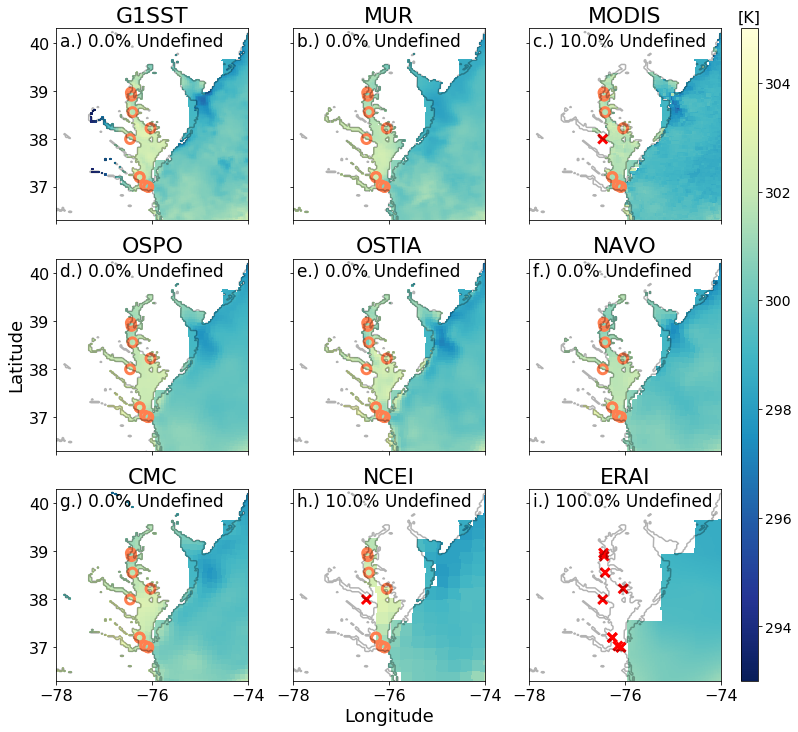

In [23]:
fig,ax = plt.subplots(ncols=3,nrows=3,figsize=(12,12),sharex=True,sharey=True)
row,col = 0,0

cmap = plt.cm.YlGnBu_r
pmin,pmax = 293,305

full_plt_order = plt_order + ['ERAI']
case_dom = [3]*len(full_plt_order)

init_met_vars = True
for ss,sst_data in enumerate(full_plt_order):
    if sst_data not in ['ERAI','FNLA','ERA5']:
        met_path = '{}met_em/ERAI/{}/raw/'.format(wrf_dir,sst_data)
    else:
        met_path = '{}met_em/{}/orig/'.format(wrf_dir,sst_data)

    met_files = sorted(glob.glob('{}met_em.d0{}*'.format(met_path,case_dom[ss])))
    met_file = met_files[0]
    met = xr.open_dataset(met_file)
    met_time = pd.to_datetime(met.Times.data[0].decode().replace('_',' '))
    if init_met_vars:
        met_lon_s = met.XLONG_C.squeeze()
        met_lat_s = met.XLAT_C.squeeze()
        met_lon = met.XLONG_M.squeeze()
        met_lat = met.XLAT_M.squeeze()
        met_landmask = met.LANDMASK.squeeze()
        init_met_vars = False
    sst = met.SST.squeeze()
    sst = sst.where(sst > 0.0)
    sst_plt = ax[row,col].pcolormesh(met_lon_s,met_lat_s,sst,
                                     norm=Normalize(pmin,pmax),cmap=cmap,
                                     rasterized=True)
    ax[row,col].contour(met_lon,met_lat,met_landmask,colors='k',alpha=0.3,levels=[0.5])
    ax[row,col].set_aspect('equal')
    ax[row,col].tick_params(labelsize=16)
    ymin,ymax = 36.3,40.3
    xmin,xmax = -78, -74
    ax[row,col].set_ylim(ymin,ymax)
    ax[row,col].set_xlim(xmin,xmax)
    ax[row,col].set_title(sst_data,size=22)
    ax[row,col].text(0.02,0.98,'{0}.) {1:3.1f}% Undefined'.format(ascii_lowercase[ss],missing_pct[sst_data]),
                     size=17,transform=ax[row,col].transAxes,ha='left',va='top')#,bbox={'fc':'w','ec':'k'})

    for bb,buoyn in enumerate(shallow_buoys):
        if buoyn in missing_stations[sst_data]:
            buoy_c = 'r'
            buoy_m = 'x'
        else:
            buoy_c = 'coral'
            buoy_m = 'o'

        stn_lat = float(buoy_ds.sel(station=buoyn).lat)
        stn_lon = float(buoy_ds.sel(station=buoyn).lon)
        ax[row,col].scatter(stn_lon,stn_lat,ec=buoy_c,marker=buoy_m,fc='none',s=80,lw=3.0)

    col += 1
    if col > 2:
        col = 0
        row += 1
        
cax  = fig.add_axes([0.92,0.125,0.02,0.755])
cbar = plt.colorbar(sst_plt,cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[K]',size=16)

ax[-1,1].set_xlabel('Longitude',size=18)
ax[1,0].set_ylabel('Latitude',size=18)

if save_figs:
    fig_name = '{}WST_MetEM_Coverage'.format(save_dir)
    plt.savefig('{}.png'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
plt.show()
            

In [24]:
sst_CBsubset_dict = {}
for ss,sst_data in enumerate(plt_order[:]):
    print(sst_data)
    init_subset = True
    if sst_data == 'MODIS':
        get_time_from_fname = True
    else:
        get_time_from_fname = False
    sst_times = get_nc_file_times(f_dir='{}{}/'.format(sst_dir,sst_data),
                                  f_grep_str='*.nc',
                                  decode_times=sst_data_dict[sst_data]['decode_times'],
                                  time_dim='time',
                                  get_time_from_fname=get_time_from_fname,
                                  f_split=['.'],
                                  time_pos=[1])
    plot_data = True
    for tt,ftime in enumerate(sst_times.keys()):
        if (ftime >= pd.to_datetime(case_start)) & (ftime <= pd.to_datetime(case_end)):
            if plot_data:
                print(ftime)
                sst_nc = xr.open_dataset(sst_times[ftime],decode_times=sst_data_dict[sst_data]['decode_times'])
                if not sst_data_dict[sst_data]['decode_times']:
                    nc_times = sst_nc[sst_data_dict[sst_data]['time_dim']].data
                    for ff,nc_time in enumerate(nc_times):
                        time_start = pd.to_datetime(sst_nc[sst_data_dict[sst_data]['time_dim']].units.replace('seconds since ',''))
                        read_time = datetime(time_start.year, time_start.month, time_start.day) + timedelta(seconds=int(nc_time))
                        if read_time == ftime:
                            ftime    = nc_time
                            fmt_time = read_time
                else:      
                    fmt_time = ftime

                if sst_data != 'MODIS':
                    sst_nc = sst_nc.sel({'time':ftime})
                else:
                    sst_nc = np.squeeze(sst_nc)
                sst = sst_nc[sst_data_dict[sst_data]['sst_name']]
                lat = sst[sst_data_dict[sst_data]['lat_name']]
                lon = sst[sst_data_dict[sst_data]['lon_name']]

                if sst_data == 'CMC':
                    landmask = sst_nc.mask
                    sst = sst.where(landmask==1)

                CBsubset_width = 5
                CBsubset_bot = 36
                CBsubset_top = CBsubset_bot + CBsubset_width 
                CBsubset_lft = -78.0
                CBsubset_rgt = CBsubset_lft + CBsubset_width
                buffer = 2
                sst_subset = sst.where(((lat >= CBsubset_bot-buffer) & (lat <= CBsubset_top+buffer) & \
                                        (lon >= CBsubset_lft-buffer) & (lon <= CBsubset_rgt+buffer)))
                if sst_data == 'MODIS':
                    sst_subset = sst_subset.rename({'latitude':'lat','longitude':'lon'})
                    sst_subset += 273.15
                sst_subset = sst_subset.dropna(dim='lat',how='all').dropna(dim='lon',how='all')
                
                sst_CBsubset_dict[sst_data] = sst_subset
                plot_data = False

G1SST
2019-07-16 00:00:00
MUR
2019-07-16 09:00:00
MODIS
2019-07-16 00:00:00
OSPO
2019-07-16 12:00:00
OSTIA
2019-07-16 12:00:00
NAVO
2019-07-16 00:00:00
CMC
2019-07-16 12:00:00
NCEI
2019-07-16 00:00:00


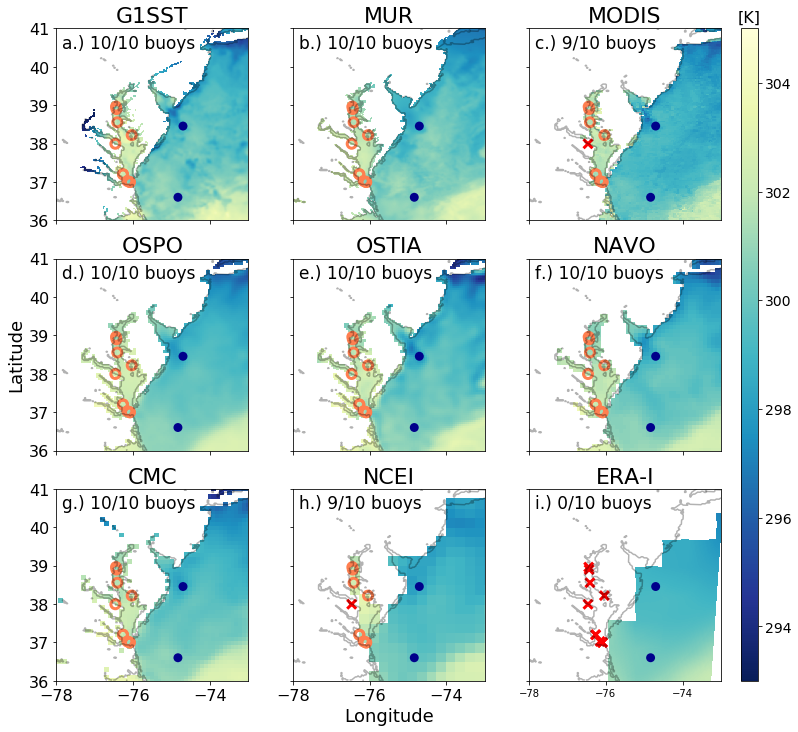

In [25]:
fig,ax = plt.subplots(ncols=3,nrows=3,figsize=(12,12),sharex=True,sharey=True)
row,col = 0,0

cmap = plt.cm.YlGnBu_r
pmin,pmax = 293,305

missing_str_fmt = 'frac' # % or frac

for ss,sst_data in enumerate(plt_order[:]):
    sst_subset = sst_CBsubset_dict[sst_data]
    sst_lon_s = 0.5*(sst_subset.lon.data[1:] + sst_subset.lon.data[:-1])
    sst_lat_s = 0.5*(sst_subset.lat.data[1:] + sst_subset.lat.data[:-1])
    sst_centered = sst_subset.data[1:,1:]
    
    sst_plt = ax[row,col].pcolormesh(sst_lon_s,sst_lat_s,sst_centered,
                                     norm=Normalize(pmin,pmax),cmap=cmap,
                                     rasterized=True)
    #sst_plt = ax[row,col].pcolormesh(sst_subset.lon,sst_subset.lat,sst_subset,
    #                                 norm=Normalize(pmin,pmax),cmap=cmap,
    #                                 rasterized=True)
    ax[row,col].contour(wrf_d03_lon,wrf_d03_lat,wrf_d03_landmask,colors='k',alpha=0.3,levels=[0.5])
    ax[row,col].set_aspect('equal')
    ax[row,col].tick_params(labelsize=16)
    ax[row,col].set_ylim((CBsubset_bot,CBsubset_top))
    ax[row,col].set_xlim((CBsubset_lft,CBsubset_rgt))
    ax[row,col].set_title(sst_data,size=22)
    label_str = '{0}.) '.format(ascii_lowercase[ss])
    if missing_str_fmt == '%':
        missing_str = '{0:3.1f}% Undefined'.format(missing_pct[sst_data])
    else:
        missing_str = '{0}/{1} buoys'.format(len(shallow_buoys)-len(missing_stations[sst_data]),len(shallow_buoys))

    ax[row,col].text(0.03,0.97,label_str+missing_str,
                     size=17,transform=ax[row,col].transAxes,ha='left',va='top',bbox={'fc':'w','ec':'none'})
    plot_data = False

    for bb,buoyn in enumerate(shallow_buoys):
        if buoyn in missing_stations[sst_data]:
            buoy_c = 'r'
            buoy_m = 'x'
        else:
            buoy_c = 'coral'
            buoy_m = 'o'

        stn_lat = float(buoy_ds.sel(station=buoyn).lat)
        stn_lon = float(buoy_ds.sel(station=buoyn).lon)
        ax[row,col].scatter(stn_lon,stn_lat,ec=buoy_c,marker=buoy_m,fc='none',s=80,lw=3.0)
        
    col += 1
    if col > 2:
        col = 0
        row += 1

wrf_d03_sst_plt = wrf_d03_sst.where(wrf_d03_sst>=10)
ax[-1,-1].pcolormesh(wrf_d03_lon,wrf_d03_lat,wrf_d03_sst_plt,
                     norm=Normalize(pmin,pmax),cmap=cmap,rasterized=True)
ax[-1,-1].contour(wrf_d03_lon,wrf_d03_lat,wrf_d03_landmask,colors='k',alpha=0.3,levels=[0.5])
ax[-1,-1].set_ylim((CBsubset_bot,CBsubset_top))
ax[-1,-1].set_xlim((CBsubset_lft,CBsubset_rgt))
ax[-1,-1].set_aspect('equal')
ax[-1,-1].set_title('ERA-I',size=22)
label_str = '{0}.) '.format(ascii_lowercase[ss+1])
sst_data = 'ERAI'
if missing_str_fmt == '%':
    missing_str = '{0:3.1f}% Undefined'.format(missing_pct[sst_data])
else:
    missing_str = '{0}/{1} buoys'.format(len(shallow_buoys)-len(missing_stations[sst_data]),len(shallow_buoys))
ax[-1,-1].text(0.03,0.97,label_str+missing_str,
                 size=17,transform=ax[row,col].transAxes,ha='left',va='top',bbox={'fc':'w','ec':'none'})
for bb,buoyn in enumerate(shallow_buoys):
    if buoyn in missing_stations[sst_data]:
        buoy_c = 'r'
        buoy_m = 'x'
    else:
        buoy_c = 'coral'
        buoy_m = 'o'

    stn_lat = float(buoy_ds.sel(station=buoyn).lat)
    stn_lon = float(buoy_ds.sel(station=buoyn).lon)
    ax[-1,-1].scatter(stn_lon,stn_lat,ec=buoy_c,marker=buoy_m,fc='none',s=80,lw=3.0)
    
for row in range(0,3):
    for col in range(0,3):
        for bb,buoyn in enumerate(deep_buoys):
            buoy_c = 'darkblue'
            buoy_m = 'o'
            stn_lat = float(buoy_ds.sel(station=buoyn).lat)
            stn_lon = float(buoy_ds.sel(station=buoyn).lon)
            ax[row,col].scatter(stn_lon,stn_lat,ec='none',marker=buoy_m,fc=buoy_c,s=80,lw=3.0)
            
cax  = fig.add_axes([0.92,0.125,0.02,0.755])
cbar = plt.colorbar(sst_plt,cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[K]',size=16)

ax[-1,1].set_xlabel('Longitude',size=18)
ax[1,0].set_ylabel('Latitude',size=18)

if save_figs:
    fig_name = '{}WST_Coverage'.format(save_dir)
    plt.savefig('{}.png'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
plt.show()
            

### Plot gradient bins:

G1SST - dx =  939.8	105
MUR - dx =  939.8	105
MODIS - dx = 4624.4	21
OSPO - dx = 4698.8	20
OSTIA - dx = 4698.8	20
NAVO - dx = 9397.7	10
CMC - dx = 9397.7	10
NCEI - dx = 23494.2	3
G1SST - dx = 1109.0	89
MUR - dx = 1109.0	89
MODIS - dx = 4624.9	21
OSPO - dx = 5544.8	17
OSTIA - dx = 5544.8	17
NAVO - dx = 11089.6	8
CMC - dx = 11089.6	8
NCEI - dx = 27723.9	3


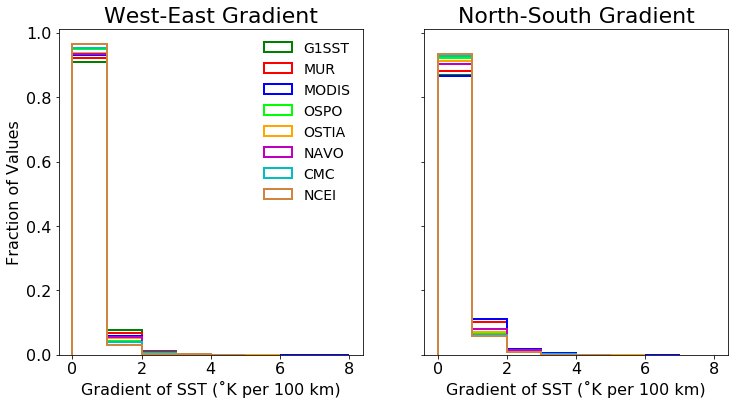

In [26]:
fig,ax = plt.subplots(ncols=2,figsize=(12,6),sharex=True,sharey=True)

for sst_data in plt_order:
    sst = sst_subset_dict[sst_data]

    dist_from_100km_x = ((sst.x.data[1:] - sst.x.data[0] - 100000.0)**2)**0.5

    inds_over_100km_x = np.where(dist_from_100km_x == np.nanmin(dist_from_100km_x))

    inds_over_100km_x = inds_over_100km_x[0][0]
    print('{0} - dx = {1:6.1f}\t{2:d}'.format(sst_data,np.nanmean(sst.x.data[1:] - sst.x.data[:-1]),inds_over_100km_x))
    
    sst_grad = np.abs(sst[sst_data_dict[sst_data]['sst_name']].data[:,:,inds_over_100km_x:] - \
                          sst[sst_data_dict[sst_data]['sst_name']].data[:,:,:-inds_over_100km_x])
    
    flat_array = sst_grad.flatten()
    flat_array = flat_array[~np.isnan(flat_array)]
    #hist,bins = np.histogram(flat_array,density=True,bins=np.linspace(0,7,8))
    #bins_s = 0.5*(bins[1:] + bins[:-1])
    bin_max = int(np.ceil(np.nanmax(flat_array)))
    ax[0].hist(flat_array,
               bins=np.linspace(0,bin_max,bin_max+1),
               density=True,
               histtype='step',
               lw=2.0,
               label=sst_data,
               color=sst_data_dict[sst_data]['color'])
#plt.yscale('log')
ax[0].legend(frameon=False,fontsize=14)


for sst_data in plt_order:
    sst = sst_subset_dict[sst_data]
    if (sst_data == 'MODIS') or (sst_data == 'NAVO'):
        sst = sst.sortby('y')
    dist_from_100km_x = ((sst.y.data[1:] - sst.y.data[0] - 100000.0)**2)**0.5
    inds_over_100km_x = np.where(dist_from_100km_x == np.nanmin(dist_from_100km_x))

    inds_over_100km_x = inds_over_100km_x[0][0]
    print('{0} - dx = {1:6.1f}\t{2:d}'.format(sst_data,np.nanmean(sst.y.data[1:] - sst.y.data[:-1]),inds_over_100km_x))
    
    sst_grad = np.abs(sst[sst_data_dict[sst_data]['sst_name']].data[:,inds_over_100km_x:,:] - \
                      sst[sst_data_dict[sst_data]['sst_name']].data[:,:-inds_over_100km_x,:])
    
    flat_array = sst_grad.flatten()
    flat_array = flat_array[~np.isnan(flat_array)]
    #hist,bins = np.histogram(flat_array,density=True,bins=np.linspace(0,7,8))
    #bins_s = 0.5*(bins[1:] + bins[:-1])
    bin_max = int(np.ceil(np.nanmax(flat_array)))
    ax[1].hist(flat_array,
               bins=np.linspace(0,bin_max,bin_max+1),
               density=True,
               histtype='step',
               lw=2.0,
               label=sst_data,
               color=sst_data_dict[sst_data]['color'])

ax[0].set_title('West-East Gradient',size=22)
ax[1].set_title('North-South Gradient',size=22)
ax[0].set_ylabel('Fraction of Values',size=16)
for axi in range(0,2):
    ax[axi].tick_params(labelsize=16)
    ax[axi].set_xlabel('Gradient of SST (˚K per 100 km)',size=16)
plt.show()

### CB Area:

In [27]:
sst_CBBarea_dict = {}
show_plot = False
for sst_data in sst_datasets[:]:
    print(sst_data)
    init_subset = True
    if sst_data == 'MODIS':
        get_time_from_fname = True
    else:
        get_time_from_fname = False
    sst_times = get_nc_file_times(f_dir='{}{}/'.format(sst_dir,sst_data),
                                  f_grep_str='*.nc',
                                  decode_times=sst_data_dict[sst_data]['decode_times'],
                                  time_dim='time',
                                  get_time_from_fname=get_time_from_fname,
                                  f_split=['.'],
                                  time_pos=[1])

    for tt,ftime in enumerate(sst_times):
    #for tt,ftime in enumerate(list(sst_times.keys())[:3]):

        if (ftime >= pd.to_datetime(case_start)) & (ftime <= pd.to_datetime(case_end)):
            sst_nc = xr.open_dataset(sst_times[ftime],decode_times=sst_data_dict[sst_data]['decode_times'])
            if not sst_data_dict[sst_data]['decode_times']:
                nc_times = sst_nc[sst_data_dict[sst_data]['time_dim']].data
                for ff,nc_time in enumerate(nc_times):
                    time_start = pd.to_datetime(sst_nc[sst_data_dict[sst_data]['time_dim']].units.replace('seconds since ',''))            
                    read_time = datetime(time_start.year, time_start.month, time_start.day) + timedelta(seconds=int(nc_time))
                    if read_time == ftime:
                        ftime    = nc_time
                        fmt_time = read_time
            else:      
                fmt_time = ftime
            
            if sst_data != 'MODIS':
                sst_nc = sst_nc.sel({'time':ftime})
            else:
                sst_nc = np.squeeze(sst_nc)

            sst = sst_nc[sst_data_dict[sst_data]['sst_name']]
            lat = sst[sst_data_dict[sst_data]['lat_name']]
            lon = sst[sst_data_dict[sst_data]['lon_name']]

            if sst_data != 'MODIS':
                landmask = sst_nc.mask
                sst = sst.where(landmask==1)

            subset_width = 6
            subset_bot = 35.0
            subset_lft = -80
            subset_top = subset_bot + subset_width
            subset_rgt = subset_lft + subset_width
            sst_subset = sst.where(((lat >= subset_bot) & (lat <= subset_top) & (lon >= subset_lft) & (lon <= subset_rgt)))
            if sst_data == 'MODIS':
                sst_subset = sst_subset.rename({'latitude':'lat','longitude':'lon'})
                sst_subset += 273.15
            sst_subset = sst_subset.dropna(dim='lat',how='all').dropna(dim='lon',how='all')
            if show_plot:
                fig,ax = plt.subplots(figsize=(16,8))
                sst_plt = ax.pcolormesh(sst_subset.lon,sst_subset.lat,sst_subset)
                plt.colorbar(sst_plt)
                ax.set_aspect('equal')
                plt.ylim((subset_bot,subset_top))
                plt.xlim((subset_lft,subset_rgt))
                ax.set_title('{} {}'.format(sst_data,np.shape(sst_subset)),size=22)
                plt.show()
                
            
            m_per_lat,m_per_lon = convert_latlon_xy(subset_bot + (subset_width/2.0))
            if sst_data == 'MODIS': 
                m_per_lon = 110986.45
                m_per_lat = 110996.61
            y = sst_subset.lat*m_per_lat 
            x = sst_subset.lon*m_per_lon
            y = y - np.min(y)
            x = x - np.min(x)
            y.name = 'y'
            x.name = 'x'
            sst_subset['y'] = y
            sst_subset['x'] = x
            sst_subset = sst_subset.drop('time')
            sst_subset['time'] = fmt_time
            sst_subset = sst_subset.expand_dims({'time':1})
            if init_subset:
                sst_CBBarea_dict[sst_data] = sst_subset
                init_subset = False
            else:
                sst_CBBarea_dict[sst_data] = sst_subset.combine_first(sst_CBBarea_dict[sst_data])
            

CMC
OSTIA
NCEI
NAVO
MUR
MODIS
G1SST
OSPO
ERAI
ERA5
FNLA


### Calculate PDF:

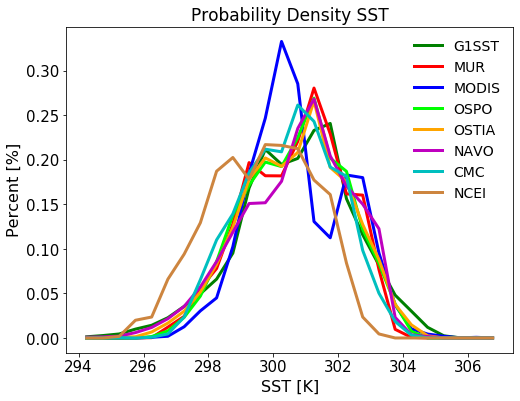

In [28]:
fig,ax = plt.subplots(figsize=(8,6))
for sst_data in plt_order:
    sst_subset = sst_CBBarea_dict[sst_data]
    
    flat_array = sst_subset.data.flatten()
    flat_array = flat_array[~np.isnan(flat_array)]
    hist,bins = np.histogram(flat_array,density=True,bins=np.linspace(294,307,27))
    bins_s = 0.5*(bins[1:] + bins[:-1])
    plt.plot(bins_s,hist,
             lw=3.0,
             label=sst_data,
             c=sst_data_dict[sst_data]['color'])
plt.tick_params(labelsize=15)
plt.legend(frameon=False,fontsize=14)
plt.title('Probability Density SST',size=17)
plt.ylabel('Percent [%]',size=16)
plt.xlabel('SST [K]',size=16)
if save_figs:
    fig_name = '{}WST_PDF'.format(save_dir)
    plt.savefig('{}.png'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
plt.show()


# Compare ICBCs

In [29]:
icbc_dict = {'ERAI' : {'color':'darkblue','sample_rate':'6h'},
             'ERA5' : {'color':'darkred','sample_rate':'1h'},
             'FNLA' : {'color':'green','sample_rate':'6h'},}

In [30]:
sample_rate = '1h'

obs_t2_f = obs_res_full.temp.rolling(datetime=13,center=False).mean().resample(datetime=sample_rate).nearest().sel(datetime=slice(case_start,case_end)) + 273.15
obs_mean_t2 = obs_t2_f.mean(dim='station')

obs_sst_f = buoy_ds.sel(station=shallow_buoys, datetime=slice(case_start,case_end)).sst.rolling(datetime=13,center=False).mean().resample(datetime=sample_rate).nearest()
obs_mean_sst  = obs_sst_f.mean(dim='station') + 273.15

obs_vel_f = obs_res_full.wspd.rolling(datetime=13,center=False).mean().resample(datetime=sample_rate).nearest().sel(datetime=slice(case_start,case_end))
obs_mean_vel = obs_vel_f.mean(dim='station')


In [31]:
save_figs = False

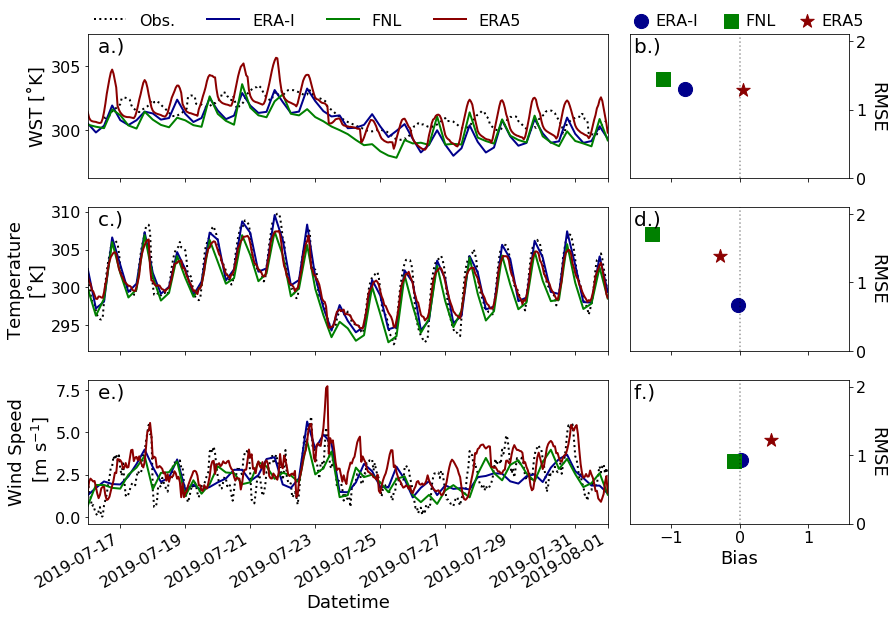

In [32]:
fig = plt.figure(figsize=(14,9))
fig.subplots_adjust(wspace=0.01)

sst_ts = plt.subplot2grid((3, 3), (0, 0), colspan=2)
sst_ts.tick_params(labelbottom=False,labelsize=16)
t2_ts = plt.subplot2grid((3, 3), (1, 0), colspan=2,sharex=sst_ts)
t2_ts.tick_params(labelbottom=False,labelsize=16)
vel_ts = plt.subplot2grid((3, 3), (2, 0), colspan=2,sharex=sst_ts)
vel_ts.tick_params(labelsize=16)

sst_err = plt.subplot2grid((3, 3), (0, 2))
sst_err.tick_params(labelbottom=False,left=False,labelleft=False,right=True,labelright=True,labelsize=16)
t2_err = plt.subplot2grid((3, 3), (1, 2),sharex=sst_err)
t2_err.tick_params(labelbottom=False,left=False,labelleft=False,right=True,labelright=True,labelsize=16)
vel_err = plt.subplot2grid((3, 3), (2, 2),sharex=sst_err)
vel_err.tick_params(left=False,labelleft=False,right=True,labelright=True,labelsize=16)


obs_mean_t2.sel(datetime=slice(case_start,case_end)).plot(ax=t2_ts,c='k',ls=':',lw=2.0,label='Obs.')
obs_mean_sst.sel(datetime=slice(case_start,case_end)).plot(ax=sst_ts,c='k',ls=':',lw=2.0,label='Obs.')
obs_mean_vel.sel(datetime=slice(case_start,case_end)).plot(ax=vel_ts,c='k',ls=':',lw=2.0)

icbc_stats = {}
for cc,icbc in enumerate(icbcs[:]):
    icbc_stats[icbc] = {'t2':{},
                        'sst':{},
                        'vel':{}}
    sample_rate = icbc_dict[icbc]['sample_rate']
    wrf_sample_rate = icbc_dict[icbc]['sample_rate']

    obs_t2 = obs_mean_t2.sel(datetime=slice(case_start,case_end)).resample(datetime=sample_rate).nearest()
    obs_sst = obs_mean_sst.sel(datetime=slice(case_start,case_end)).resample(datetime=sample_rate).nearest()
    obs_vel = obs_mean_vel.sel(datetime=slice(case_start,case_end)).resample(datetime=sample_rate).nearest()

    icbc_col = sst_data_dict[icbc]['color']
    if sst_dataset == 'FNLA':
        sst_name = 'tsk'
    else:
        sst_name = 'sst'
    sim_t2 = wrf_stn_dict[icbc].sel(datetime=slice(case_start,case_end)).mean(dim='station').t2.resample(
                                                                        datetime=wrf_sample_rate).nearest()
    sim_sst = wrf_buoy_dict[icbc].sel(datetime=slice(case_start,case_end)).mean(dim='station')[sst_name].resample(
                                                                        datetime=wrf_sample_rate).nearest()
    sim_vel = wrf_stn_dict[icbc].sel(datetime=slice(case_start,case_end)).mean(dim='station').vel10.resample(
                                                                        datetime=wrf_sample_rate).nearest()

    sim_t2.plot(ax=t2_ts,c=icbc_col,lw=2.0,)
    sim_sst.plot(ax=sst_ts,c=icbc_col,lw=2.0,label=sst_data_dict[icbc]['name'])
    sim_vel.plot(ax=vel_ts,c=icbc_col,lw=2.0)

    for vv,var in enumerate(['t2','sst','vel']):
        if var == 't2':
            obs = obs_t2
            sim = sim_t2
        elif var == 'sst':
            obs = obs_sst
            sim = sim_sst
        elif var == 'vel':
            obs = obs_vel
            sim = sim_vel
        var_bias = (sim - obs).mean().data
        var_rmse = (((sim - obs)**2).mean().data)**0.5

        if (np.any(np.isnan(sim))) or (np.any(np.isnan(obs))):
            r2 = np.nan
        else:
            r2,_ = pearsonr(sim, obs)

        icbc_stats[icbc][var]['bias'] = var_bias
        icbc_stats[icbc][var]['rmse'] = var_rmse
        icbc_stats[icbc][var]['corr'] = r2
        
sst_ts.set_xlim(sim_sst.datetime.data[0],sim_sst.datetime.data[-1])
sst_ts.set_ylim(float(obs_sst.min())-3,float(obs_sst.max())+4)
t2_ts.set_ylabel('Temperature\n[˚K]',size=18)
sst_ts.set_ylabel('WST [˚K]',size=18)
vel_ts.set_ylabel('Wind Speed\n [m s$^{-1}$]',size=18)
t2_ts.set_xlabel('',size=18)
sst_ts.set_xlabel('',size=18)
vel_ts.set_xlabel('Datetime',size=18)
sst_ts.legend(frameon=False,fontsize=16,loc=(0.0,1.0),ncol=4)

for vv,var in enumerate(['t2','sst','vel']):
    if var == 't2':
        title_str = 'T2'
        ax = t2_err
    elif var == 'sst':
        title_str = 'WST'
        ax = sst_err
    elif var == 'vel':
        title_str = 'Wind Speed'
        ax = vel_err
    #ax.set_title(title_str,size=22)
    for cc,icbc in enumerate(icbcs):
        mb_point = icbc_stats[icbc][var]['bias']
        mr_point = icbc_stats[icbc][var]['rmse']
        ax.scatter(mb_point,mr_point,
                       c=sst_data_dict[icbc]['color'],
                       label=sst_data_dict[icbc]['name'],
                       marker=sst_data_dict[icbc]['marker'],
                       s=200)
        
    ax.set_xlim(-1.6,1.6)
    ax.set_ylim(0,2.1)
    ax.set_xlabel('')
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('RMSE',size=18,rotation=270,labelpad=20)
    ax.tick_params(labelsize=16)
    ax.axvline(0.0,ls=':',c='k',alpha=0.4)
    ax.set_aspect('equal')
sst_err.legend(frameon=False,fontsize=16,loc=(-0.05,1.0),ncol=3,columnspacing=1.0,handletextpad=-0.1)
vel_err.set_xlabel('Bias',size=18)

sst_ts.text(0.02,0.98,'{}.) '.format(ascii_lowercase[0]),size=20,transform=sst_ts.transAxes,ha='left',va='top')
sst_err.text(0.02,0.98,'{}.) '.format(ascii_lowercase[1]),size=20,transform=sst_err.transAxes,ha='left',va='top')

t2_ts.text(0.02,0.98,'{}.) '.format(ascii_lowercase[2]),size=20,transform=t2_ts.transAxes,ha='left',va='top')
t2_err.text(0.02,0.98,'{}.) '.format(ascii_lowercase[3]),size=20,transform=t2_err.transAxes,ha='left',va='top')

vel_ts.text(0.02,0.98,'{}.) '.format(ascii_lowercase[4]),size=20,transform=vel_ts.transAxes,ha='left',va='top')
vel_err.text(0.02,0.98,'{}.) '.format(ascii_lowercase[5]),size=20,transform=vel_err.transAxes,ha='left',va='top')
save_figs = False
if save_figs:
    fig_name = '{}ICBC_Comparison'.format(save_dir)
    plt.savefig('{}.png'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

In [33]:
best_icbc = 'ERAI'
sample_rate = icbc_dict[best_icbc]['sample_rate']

In [34]:
new_plt_order = plt_order.copy()
new_plt_order.insert(0,best_icbc)

In [35]:
sst_stats = {}

for ss,sst_data in enumerate(new_plt_order):
    sst_stats[sst_data] = {'bias' : {},
                           'rmse' : {},
                           'corr' : {}}
    sample_rate = icbc_dict[best_icbc]['sample_rate']
    missing_buoys = 0
    sst_bias = 0
    sst_rmse = 0
    sst_corr = 0
    corr_count = 0
    if sst_data == best_icbc:
        buoy_data_ds = wrf_buoy_dict[sst_data].resample(datetime=sample_rate).mean()
        #time_offset = pd.to_datetime(buoy_data_ds.datetime.data[0]).hour
    else:
        buoy_data_ds = wrf_buoy_dict[sst_data]
    time_offset = pd.to_datetime(buoy_data_ds.datetime.data[0]).hour

    for bb,buoyn in enumerate(shallow_buoys):
        buoy_obs = obs_sst_f.sel(station=buoyn).resample(datetime=sample_rate).mean() + 273.15

        #if sst_data == best_icbc:
        #    buoy_sim = wrf_buoy_dict[sst_data].sel(station=buoyn,datetime=slice(case_start,case_end)).sst.resample(
                                #datetime=sample_rate).nearest()
        #    buoy_sim += float(wrf_buoy_dict[sst_data].sel(station=buoyn,datetime=slice(case_start,case_end)).tsk.resample(
                                #datetime=sample_rate).nearest()[0])
        #else:
        #    buoy_sim = wrf_buoy_dict[sst_data].sel(station=buoyn,datetime=slice(case_start,case_end)).sst.resample(
                                #datetime=sample_rate).nearest()
        buoy_sim = wrf_buoy_dict[sst_data].sel(station=buoyn,datetime=slice(case_start,case_end)).sst.resample(
                                                                                datetime=sample_rate).nearest()

        if len(buoy_sim.where(buoy_sim > 0).dropna(how='any',dim='datetime')) == 0:
            buoy_sim = wrf_buoy_dict[sst_data].sel(station=buoyn,datetime=slice(case_start,case_end)).tsk.resample(
                                                                                datetime=sample_rate).nearest()

        #buoy_sim = delT_dict[sst_data][stn]['sst']

        buoy_sim = buoy_sim.where(~np.isnan(buoy_obs))
        buoy_obs = buoy_obs.dropna(how='any',dim='datetime')
        buoy_sim = buoy_sim.dropna(how='any',dim='datetime')
        
        #buoy_obs.plot(c='k')
        #buoy_sim.plot()
        buoy_bias = (buoy_sim - buoy_obs).mean().data
        buoy_rmse = (((buoy_sim - buoy_obs)**2).mean().data)**0.5
        
        if bool(np.any(np.isnan(buoy_sim))) or (np.any(np.isnan(buoy_obs))):
            r2 = np.nan
            print((np.any(np.isnan(buoy_sim))) , (np.any(np.isnan(buoy_obs))))
        else:
            r2,_ = pearsonr(buoy_sim, buoy_obs)
            sst_corr += r2
            corr_count += 1
        #print(corr_count)
        sst_stats[sst_data]['bias'][buoyn] = buoy_bias
        sst_stats[sst_data]['rmse'][buoyn] = buoy_rmse
        sst_stats[sst_data]['corr'][buoyn] = r2

        if ~np.isnan(buoy_bias):
            sst_bias += buoy_bias
            sst_rmse += buoy_rmse

        else:
            missing_buoys += 1
        #print('{}: bias = {}, error = {}'.format(buoy,buoy_bias,buoy_rmse))
    #ax[col,row].legend()

    #plt.show()
    n_stations_with_data = (len(shallow_buoys)-missing_buoys)
    sst_stats[sst_data]['bias']['mean'] = sst_bias / n_stations_with_data
    sst_stats[sst_data]['rmse']['mean'] = sst_rmse / n_stations_with_data
    sst_stats[sst_data]['corr']['mean'] = sst_corr / corr_count    


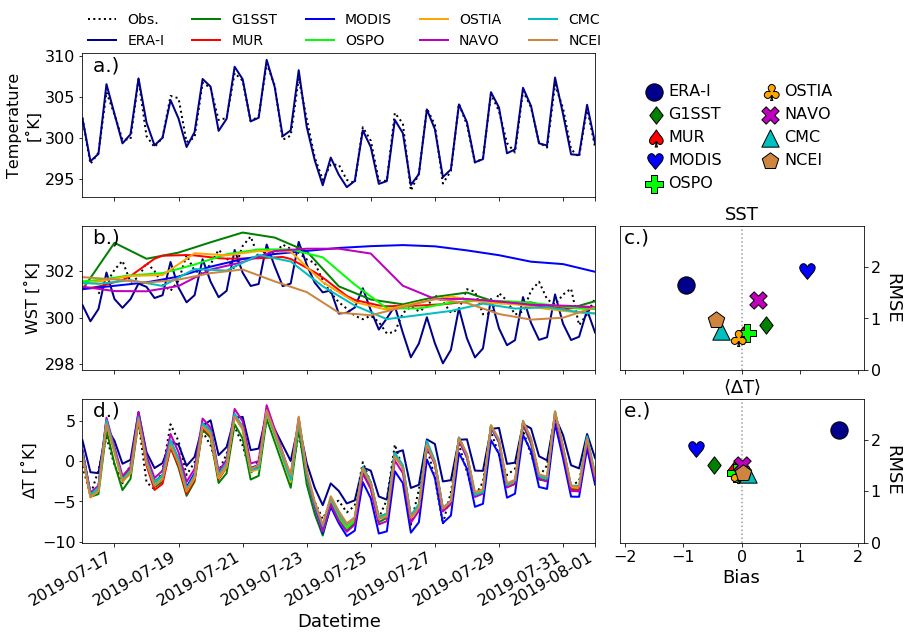

In [36]:
fig = plt.figure(figsize=(14,9))
fig.subplots_adjust(wspace=0.1)
sample_rate = icbc_dict[best_icbc]['sample_rate']

mean_calc = 'ind' # ind or all

t2_ts = plt.subplot2grid((3, 3), (0, 0), colspan=2)
t2_ts.tick_params(labelbottom=False,labelsize=16)
sst_ts = plt.subplot2grid((3, 3), (1, 0), colspan=2,sharex=t2_ts)
sst_ts.tick_params(labelbottom=False,labelsize=16)
dt_ts = plt.subplot2grid((3, 3), (2, 0), colspan=2,sharex=t2_ts)
dt_ts.tick_params(labelsize=16)

#t2_err = plt.subplot2grid((3, 3), (0, 2))
#t2_err.tick_params(labelbottom=False,left=False,labelleft=False,right=True,labelright=True,labelsize=16)
sst_err = plt.subplot2grid((3, 3), (1, 2))
sst_err.tick_params(labelbottom=False,left=False,labelleft=False,right=True,labelright=True,labelsize=16)
dt_err = plt.subplot2grid((3, 3), (2, 2),sharex=sst_err)
dt_err.tick_params(left=False,labelleft=False,right=True,labelright=True,labelsize=16)

obs_mean_t2.sel(datetime=slice(case_start,case_end)).resample(datetime=sample_rate).nearest().plot(ax=t2_ts,c='k',ls=':',lw=2.0)
wrf_stn_dict[best_icbc].sel(datetime=slice(case_start,case_end)).mean(dim='station').t2.resample(
                                                            datetime=sample_rate).nearest().plot(ax=t2_ts,c='darkblue',lw=2.0)



    #sim_t2 = wrf_stn_dict[icbc].sel(datetime=slice(case_start,case_end)).mean(dim='station').t2.resample(
                            #datetime=wrf_sample_rate).nearest()
    #sim_sst = wrf_buoy_dict[icbc].sel(datetime=slice(case_start,case_end)).mean(dim='station')[sst_name].resample(
                            #datetime=wrf_sample_rate).nearest()
    #sim_vel = wrf_stn_dict[icbc].sel(datetime=slice(case_start,case_end)).mean(dim='station').vel10.resample(
                            #datetime=wrf_sample_rate).nearest()


    #obs_res_full['delT'] = del_T
    #obs_res_full['delT_mean'] = delT_mean
    #wrf_stn_dict[sst_dataset]['delT'] = del_T
    #wrf_stn_dict[sst_dataset]['delT_mean'] = delT_mean


obs_mean_sst.sel(datetime=slice(case_start,case_end)).resample(datetime=sample_rate).nearest().plot(ax=sst_ts,c='k',ls=':',lw=2.0)
#wrf_mean_sst.sel(datetime=slice(case_start,case_end)).plot(ax=ax[1],c='darkblue',lw=2.0)

#del_t_dict[best_icbc]['obs'].sel(datetime=slice(case_start,case_end)).plot(ax=dt_ts,c='k',ls=':',lw=2.0,label='Obs.')
#delT_dict['obs']['mean']['delTK_{}'.format(mean_calc)].plot(ax=dt_ts,c='k',ls=':',lw=2.0,label='Obs.')
if mean_calc == 'all':
    obs_res_full.delT_mean.sel(datetime=slice(case_start,case_end)).resample(
                            datetime=sample_rate).nearest().plot(ax=dt_ts,c='k',ls=':',lw=2.0,label='Obs.')
else:
    obs_res_full.delT.sel(datetime=slice(case_start,case_end)).resample(
                            datetime=sample_rate).nearest().mean(dim='station').plot(ax=dt_ts,c='k',ls=':',lw=2.0,label='Obs.')
#del_t_dict['wrf'].sel(datetime=slice(case_start,case_end)).plot(ax=ax[2],c='darkblue',lw=2.0,label='ERA-I')

del_t_stats = {}

for ss,sst_data in enumerate(new_plt_order):
    plot_this = True

    
    if sst_data == best_icbc:
        #sst = new_sst_data[sst_data].tsk.mean(dim='station').resample(datetime=sample_rate).nearest()
        sst = wrf_buoy_dict[sst_data].tsk.mean(dim='station').resample(datetime=sample_rate).nearest()
        sst = sst.sel(datetime=slice(case_start,case_end))   
        lc = 'darkblue'
        plt_lbl = 'ERA-I'
    else:
        good_stations = shallow_buoys.copy()
        missing_stns = missing_stations[sst_data]
        for mstn in missing_stns: good_stations.remove(mstn)
        sst = wrf_buoy_dict[sst_data].sst.sel(station=good_stations).copy()
        sst = sst.mean(dim='station').resample(datetime=sample_rate).nearest()
        sst = sst.sel(datetime=slice(case_start,case_end))
        #sst = sst.rename({'time':'datetime'})
        lc  = sst_data_dict[sst_data]['color']
        plt_lbl = sst_data

    sst.plot(ax=sst_ts,
             c=lc,
             lw=2.0)
    
    #del_t = del_t_dict[best_icbc][sst_data].sel(datetime=slice(case_start,case_end))

    if mean_calc == 'all':
        del_t = wrf_stn_dict[sst_data].delT_mean.sel(datetime=slice(case_start,case_end))
        del_t_obs = obs_res_full.delT_mean.resample(datetime=sample_rate).nearest().sel(datetime=slice(case_start,case_end))
        #del_t = delT_dict[sst_data]['mean']['delTK_{}'.format(mean_calc)].sel(datetime=slice(case_start,case_end))
        #del_t_obs = delT_dict['obs']['mean']['delTK_{}'.format(mean_calc)].sel(datetime=slice(del_t.datetime[0],del_t.datetime[-1]))
    else:
        del_t = wrf_stn_dict[sst_data].delT.mean(dim='station').sel(datetime=slice(case_start,case_end))
        del_t_obs = obs_res_full.delT.mean(dim='station').resample(datetime=sample_rate).nearest().sel(datetime=slice(case_start,case_end))
        del_t = del_t.where(~np.isnan(del_t_obs))
        del_t_obs = del_t_obs.dropna(how='any',dim='datetime')
        del_t = del_t.dropna(how='any',dim='datetime')

    del_t.plot(ax=dt_ts,
               c=lc,
               lw=2.0,
               label=plt_lbl)

    del_t_bias = (del_t - del_t_obs).mean().data
    del_t_rmse = (((del_t - del_t_obs)**2).mean().data)**0.5
    r2,_ = pearsonr(del_t, del_t_obs)

    del_t_stats[sst_data] = {'bias':del_t_bias,
                             'rmse':del_t_rmse,
                             'corr':r2}


    mb_point = sst_stats[sst_data]['bias']['mean']
    mr_point = sst_stats[sst_data]['rmse']['mean']

    if sst_data == 'ERAI':
        plt_lbl = 'ERA-I'
    else:
        plt_lbl = sst_data
    
    sst_err.scatter(mb_point,mr_point,
                c=sst_data_dict[sst_data]['color'],
                marker=sst_data_dict[sst_data]['marker'],
                label=plt_lbl,
                s=300,
                ec='k',
                zorder=100)

    for bb,bouyn in enumerate(shallow_buoys):
        b_point = sst_stats[sst_data]['bias'][bouyn]
        r_point = sst_stats[sst_data]['rmse'][bouyn]
        add_small_markers = False
        if add_small_markers:
            sst_err.plot([mb_point,b_point],[mr_point,r_point],
                     c=sst_data_dict[sst_data]['color'],
                     lw=0.5,
                     alpha=0.5)
            sst_err.scatter(b_point,r_point,
                        c=sst_data_dict[sst_data]['color'],
                        marker='.',
                        alpha=0.5,
                        s=40)

    lc  = sst_data_dict[sst_data]['color']
    if sst_data != 'ERAI':
        plt_lbl = sst_data
    else:
        #lc = 'darkblue'
        plt_lbl = 'ERA-I'
    mb_point = del_t_stats[sst_data]['bias']
    mr_point = del_t_stats[sst_data]['rmse']
    #marker_str = '{0} (r = {1:3.1f})'.format(sst_data,del_t_stats[sst_data]['corr'])
    dt_err.scatter(mb_point,mr_point,
                c=lc,
                ec='k',
                marker=sst_data_dict[sst_data]['marker'],
                label=plt_lbl,
                s=300,
                zorder=100)


dt_ts.legend(frameon=False,loc=(0.0,3.4),fontsize=14,ncol=5)
t2_ts.set_ylabel('Temperature\n[˚K]',size=16)
sst_ts.set_ylabel('WST [˚K]',size=16)
dt_ts.set_ylabel('∆T [˚K]',size=16)

t2_ts.set_title('')
sst_ts.set_title('')
dt_ts.set_title('')

t2_ts.set_xlabel('')
sst_ts.set_xlabel('')
dt_ts.set_xlabel('Datetime',size=18)
t2_ts.set_xlim(sst.datetime.data[0],sst.datetime.data[-1])

#ax[0].set_title(r'$\langle$SST$\rangle$',size=18)
sst_err.set_title('SST',size=18)
sst_err.set_ylabel('RMSE',size=16)
sst_err.axvline(0.0,ls=':',c='k',alpha=0.4)
#sst_err.tick_params(labelsize=16)

dt_err.set_ylim(0.0,2.8)
dt_err.set_xlim(-2.1,2.1)
sst_err.legend(frameon=False,loc=(0.05,1.2),fontsize=16,handletextpad=-0.1,ncol=2)
dt_err.set_title(r'$\langle$∆T$\rangle$',size=18)
dt_err.set_xlabel('Bias',size=18)
#dt_err.set_ylabel('RMSE',size=16)
dt_err.axvline(0.0,ls=':',c='k',alpha=0.4)

sst_err.set_ylim(0.0,2.8)
sst_err.yaxis.set_label_position("right")
sst_err.set_ylabel('RMSE',size=18,rotation=270,labelpad=20)

dt_err.yaxis.set_label_position("right")
dt_err.set_ylabel('RMSE',size=18,rotation=270,labelpad=20)

t2_ts.text(0.02,0.98,'{}.) '.format(ascii_lowercase[0]),size=20,transform=t2_ts.transAxes,ha='left',va='top')
sst_ts.text(0.02,0.98,'{}.) '.format(ascii_lowercase[1]),size=20,transform=sst_ts.transAxes,ha='left',va='top')
sst_err.text(0.02,0.98,'{}.) '.format(ascii_lowercase[2]),size=20,transform=sst_err.transAxes,ha='left',va='top')
dt_ts.text(0.02,0.98,'{}.) '.format(ascii_lowercase[3]),size=20,transform=dt_ts.transAxes,ha='left',va='top')
dt_err.text(0.02,0.98,'{}.) '.format(ascii_lowercase[4]),size=20,transform=dt_err.transAxes,ha='left',va='top')
save_figs = True
if save_figs:
    fig_name = '{}ICBC_DT_Comparison'.format(save_dir)
    plt.savefig('{}.png'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

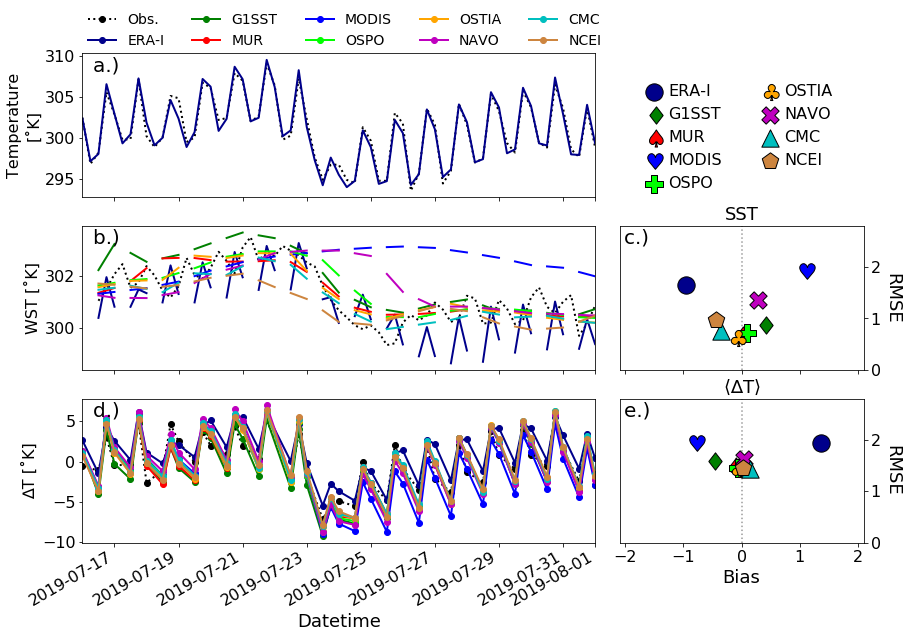

In [51]:
fig = plt.figure(figsize=(14,9))
fig.subplots_adjust(wspace=0.1)
sample_rate = icbc_dict[best_icbc]['sample_rate']

mean_calc = 'ind' # ind or all

t2_ts = plt.subplot2grid((3, 3), (0, 0), colspan=2)
t2_ts.tick_params(labelbottom=False,labelsize=16)
sst_ts = plt.subplot2grid((3, 3), (1, 0), colspan=2,sharex=t2_ts)
sst_ts.tick_params(labelbottom=False,labelsize=16)
dt_ts = plt.subplot2grid((3, 3), (2, 0), colspan=2,sharex=t2_ts)
dt_ts.tick_params(labelsize=16)

#t2_err = plt.subplot2grid((3, 3), (0, 2))
#t2_err.tick_params(labelbottom=False,left=False,labelleft=False,right=True,labelright=True,labelsize=16)
sst_err = plt.subplot2grid((3, 3), (1, 2))
sst_err.tick_params(labelbottom=False,left=False,labelleft=False,right=True,labelright=True,labelsize=16)
dt_err = plt.subplot2grid((3, 3), (2, 2),sharex=sst_err)
dt_err.tick_params(left=False,labelleft=False,right=True,labelright=True,labelsize=16)

obs_mean_t2.sel(datetime=slice(case_start,case_end)).resample(datetime=sample_rate).nearest().plot(ax=t2_ts,c='k',ls=':',lw=2.0)
wrf_stn_dict[best_icbc].sel(datetime=slice(case_start,case_end)).mean(dim='station').t2.resample(
                                                            datetime=sample_rate).nearest().plot(ax=t2_ts,c='darkblue',lw=2.0)


obs_mean_sst.sel(datetime=slice(case_start,case_end)).resample(datetime=sample_rate).nearest().plot(ax=sst_ts,c='k',ls=':',lw=2.0)
#wrf_mean_sst.sel(datetime=slice(case_start,case_end)).plot(ax=ax[1],c='darkblue',lw=2.0)

#del_t_dict[best_icbc]['obs'].sel(datetime=slice(case_start,case_end)).plot(ax=dt_ts,c='k',ls=':',lw=2.0,label='Obs.')
#delT_dict['obs']['mean']['delTK_{}'.format(mean_calc)].plot(ax=dt_ts,c='k',ls=':',lw=2.0,label='Obs.')
if mean_calc == 'all':
    obs_res_full.delT_mean.sel(datetime=slice(case_start,case_end)).resample(
                            datetime=sample_rate).nearest().plot(ax=dt_ts,c='k',ls=':',lw=2.0,label='Obs.')
else:
    del_t_obs = obs_res_full.delT.sel(datetime=slice(case_start,case_end)).resample(
                            datetime=sample_rate).nearest().mean(dim='station')
    #del_t_obs.plot(ax=dt_ts,c='k',ls=':',lw=2.0,label='Obs.')
#del_t_dict['wrf'].sel(datetime=slice(case_start,case_end)).plot(ax=ax[2],c='darkblue',lw=2.0,label='ERA-I')


del_t_stats = {}

for ss,sst_data in enumerate(new_plt_order):
    plot_this = True

    
    if sst_data == best_icbc:
        #sst = new_sst_data[sst_data].tsk.mean(dim='station').resample(datetime=sample_rate).nearest()
        sst = wrf_buoy_dict[sst_data].tsk.mean(dim='station').resample(datetime=sample_rate).nearest()
        sst = sst.sel(datetime=slice(case_start,case_end))   
        lc = 'darkblue'
        plt_lbl = 'ERA-I'
    else:
        good_stations = shallow_buoys.copy()
        missing_stns = missing_stations[sst_data]
        for mstn in missing_stns: good_stations.remove(mstn)
        sst = wrf_buoy_dict[sst_data].sst.sel(station=good_stations).copy()
        sst = sst.mean(dim='station').resample(datetime=sample_rate).nearest()
        sst = sst.sel(datetime=slice(case_start,case_end))
        #sst = sst.rename({'time':'datetime'})
        lc  = sst_data_dict[sst_data]['color']
        plt_lbl = sst_data

        

    # Only daytime:
    sst_h = []
    for h in sst.datetime: sst_h += [pd.to_datetime(h.data).hour]
    sst_h = np.asarray(sst_h)
    sst = sst.where((sst_h > 10) | (sst_h == 0))

        
    sst.plot(ax=sst_ts,
             c=lc,
             lw=2.0)
    
    #del_t = del_t_dict[best_icbc][sst_data].sel(datetime=slice(case_start,case_end))

    if mean_calc == 'all':
        del_t = wrf_stn_dict[sst_data].delT_mean.sel(datetime=slice(case_start,case_end))
        del_t_obs = obs_res_full.delT_mean.resample(datetime=sample_rate).nearest().sel(datetime=slice(case_start,case_end))
        #del_t = delT_dict[sst_data]['mean']['delTK_{}'.format(mean_calc)].sel(datetime=slice(case_start,case_end))
        #del_t_obs = delT_dict['obs']['mean']['delTK_{}'.format(mean_calc)].sel(datetime=slice(del_t.datetime[0],del_t.datetime[-1]))
    else:
        del_t = wrf_stn_dict[sst_data].delT.mean(dim='station').sel(datetime=slice(case_start,case_end))
        del_t_obs = obs_res_full.delT.mean(dim='station').resample(datetime=sample_rate).nearest().sel(datetime=slice(case_start,case_end))
        del_t = del_t.where(~np.isnan(del_t_obs))
        del_t_obs = del_t_obs.dropna(how='any',dim='datetime')
        del_t = del_t.dropna(how='any',dim='datetime')

        
    # Only daytime:
    delT_h = []
    for h in del_t.datetime: delT_h += [pd.to_datetime(h.data).hour]
    delT_h = np.asarray(delT_h)
    del_t = del_t.where((delT_h > 10) | (delT_h == 0))

    delT_h = []
    for h in del_t_obs.datetime: delT_h += [pd.to_datetime(h.data).hour]
    delT_h = np.asarray(delT_h)
    del_t_obs = del_t_obs.where((delT_h > 10) | (delT_h == 0))
        
        
    del_t = del_t.dropna(how='all',dim='datetime')
    del_t_obs = del_t_obs.dropna(how='all',dim='datetime')
        
    if ss == 0:
        del_t_obs.plot(ax=dt_ts,c='k',ls=':',lw=2.0,label='Obs.',marker='o')

    del_t.plot(ax=dt_ts,
               c=lc,
               lw=2.0,
               label=plt_lbl,marker='o')

    del_t_bias = (del_t - del_t_obs).mean().data
    del_t_rmse = (((del_t - del_t_obs)**2).mean().data)**0.5
    r2,_ = pearsonr(del_t, del_t_obs)

    del_t_stats[sst_data] = {'bias':del_t_bias,
                             'rmse':del_t_rmse,
                             'corr':r2}


    mb_point = sst_stats[sst_data]['bias']['mean']
    mr_point = sst_stats[sst_data]['rmse']['mean']

    if sst_data == 'ERAI':
        plt_lbl = 'ERA-I'
    else:
        plt_lbl = sst_data
    
    sst_err.scatter(mb_point,mr_point,
                c=sst_data_dict[sst_data]['color'],
                marker=sst_data_dict[sst_data]['marker'],
                label=plt_lbl,
                s=300,
                ec='k',
                zorder=100)

    for bb,bouyn in enumerate(shallow_buoys):
        b_point = sst_stats[sst_data]['bias'][bouyn]
        r_point = sst_stats[sst_data]['rmse'][bouyn]
        add_small_markers = False
        if add_small_markers:
            sst_err.plot([mb_point,b_point],[mr_point,r_point],
                     c=sst_data_dict[sst_data]['color'],
                     lw=0.5,
                     alpha=0.5)
            sst_err.scatter(b_point,r_point,
                        c=sst_data_dict[sst_data]['color'],
                        marker='.',
                        alpha=0.5,
                        s=40)

    lc  = sst_data_dict[sst_data]['color']
    if sst_data != 'ERAI':
        plt_lbl = sst_data
    else:
        #lc = 'darkblue'
        plt_lbl = 'ERA-I'
    mb_point = del_t_stats[sst_data]['bias']
    mr_point = del_t_stats[sst_data]['rmse']
    #marker_str = '{0} (r = {1:3.1f})'.format(sst_data,del_t_stats[sst_data]['corr'])
    dt_err.scatter(mb_point,mr_point,
                c=lc,
                ec='k',
                marker=sst_data_dict[sst_data]['marker'],
                label=plt_lbl,
                s=300,
                zorder=100)


dt_ts.legend(frameon=False,loc=(0.0,3.4),fontsize=14,ncol=5)
t2_ts.set_ylabel('Temperature\n[˚K]',size=16)
sst_ts.set_ylabel('WST [˚K]',size=16)
dt_ts.set_ylabel('∆T [˚K]',size=16)

t2_ts.set_title('')
sst_ts.set_title('')
dt_ts.set_title('')

t2_ts.set_xlabel('')
sst_ts.set_xlabel('')
dt_ts.set_xlabel('Datetime',size=18)
t2_ts.set_xlim(sst.datetime.data[0],sst.datetime.data[-1])

#ax[0].set_title(r'$\langle$SST$\rangle$',size=18)
sst_err.set_title('SST',size=18)
sst_err.set_ylabel('RMSE',size=16)
sst_err.axvline(0.0,ls=':',c='k',alpha=0.4)
#sst_err.tick_params(labelsize=16)

dt_err.set_ylim(0.0,2.8)
dt_err.set_xlim(-2.1,2.1)
sst_err.legend(frameon=False,loc=(0.05,1.2),fontsize=16,handletextpad=-0.1,ncol=2)
dt_err.set_title(r'$\langle$∆T$\rangle$',size=18)
dt_err.set_xlabel('Bias',size=18)
#dt_err.set_ylabel('RMSE',size=16)
dt_err.axvline(0.0,ls=':',c='k',alpha=0.4)

sst_err.set_ylim(0.0,2.8)
sst_err.yaxis.set_label_position("right")
sst_err.set_ylabel('RMSE',size=18,rotation=270,labelpad=20)

dt_err.yaxis.set_label_position("right")
dt_err.set_ylabel('RMSE',size=18,rotation=270,labelpad=20)

t2_ts.text(0.02,0.98,'{}.) '.format(ascii_lowercase[0]),size=20,transform=t2_ts.transAxes,ha='left',va='top')
sst_ts.text(0.02,0.98,'{}.) '.format(ascii_lowercase[1]),size=20,transform=sst_ts.transAxes,ha='left',va='top')
sst_err.text(0.02,0.98,'{}.) '.format(ascii_lowercase[2]),size=20,transform=sst_err.transAxes,ha='left',va='top')
dt_ts.text(0.02,0.98,'{}.) '.format(ascii_lowercase[3]),size=20,transform=dt_ts.transAxes,ha='left',va='top')
dt_err.text(0.02,0.98,'{}.) '.format(ascii_lowercase[4]),size=20,transform=dt_err.transAxes,ha='left',va='top')
save_figs = True
if save_figs:
    fig_name = '{}ICBC_DT_Comparison_daytime'.format(save_dir)
    plt.savefig('{}.png'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

# LB-Index (Biggs and Graves, 1962) Guesswork

## Using individual stations (similar to MBDA):

\begin{table}
\begin{center}
\caption{\label{table:LBI}}
\bgroup
\def\arraystretch{1.5}
\begin{tabular}{|c|c|c|}
\hline
\textbf{WST Dataset} & \textbf{LBI-Predicted WB Breezes} & \textbf{LBI-Predicted WB Breeze Days} \\
\hline
ERA-I & 64 & 12\\
G1SST & 42 & 11\\
MUR & 50 & 12\\
MODIS & 37 & 11\\
OSPO & 51 & 12\\
OSTIA & 51 & 12\\
NAVO & 52 & 12\\
CMC & 56 & 12\\
NCEI & 54 & 12\\
\hline
\end{tabular}
\egroup
\end{center}
\end{table}


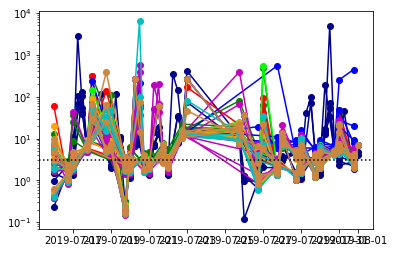

45.2% at hour 00
 0.0% at hour 06
 0.0% at hour 12
54.8% at hour 18


In [44]:
print(r'\begin{table}')
print(r'\begin{center}')
print(r'\caption{\label{table:LBI}}')
print(r'\bgroup')
print(r'\def\arraystretch{1.5}')
print(r'\begin{tabular}{|c|c|c|}')
print(r'\hline')
print(r'\textbf{WST Dataset} & \textbf{LBI-Predicted WB Breezes} & \textbf{LBI-Predicted WB Breeze Days} \\')
print(r'\hline')

Cp = 1.003
# Start time:     0900 Local (1300 UTC) 
start_time = 0
# End time:       1600 Local (2000 UTC)
end_time   = 23

lbi_predictions = {}

total_breezes = {'00':0,'06':0,'12':0,'18':0}
for ss,sst_data in enumerate(new_plt_order):
    bb_days = []
    num_breezes = 0
    lbi_predictions[sst_data] = {'breezes' : 0, 'days': 0}
    
    for ss,stn in enumerate(near_shore_stations):
        U_kts = wrf_stn_dict[sst_data].vel10.sel(station=stn,datetime=slice(case_start,case_end))*1.94384
        del_tF = wrf_stn_dict[sst_data].delT_F.sel(station=stn,datetime=slice(case_start,case_end))
        LBI = (U_kts**2)/(Cp*del_tF)
        LBI = LBI.where(LBI>0).dropna(how='any',dim='datetime')
        plt.semilogy(LBI.datetime,LBI,marker='o',c=sst_data_dict[sst_data]['color'])
        LBI_bb = LBI.where(LBI<=3.0).dropna(how='any',dim='datetime')
        bb_day_list = []
        bb_stn_list = []
        for day in LBI_bb.datetime:
            # limit to 1 station per day...
            bb_time = pd.to_datetime(day.data)
            if ((bb_time.hour >= start_time) and (bb_time.hour <= end_time)):# or bb_time.hour == 0:
                bb_stn = str(day.station.data)
                bb_datetime = '{0:04d}-{1:02d}-{2:02d}'.format(bb_time.year,bb_time.month,bb_time.day)
                bb_day_list.append('{0} {1:02d}'.format(bb_datetime,bb_time.hour))
                bb_stn_list.append('{}_{}'.format(bb_stn,bb_datetime))

        num_breezes += len(np.unique(bb_stn_list))
        
        for bb in bb_day_list:
            total_breezes[bb[-2:]] += 1
        
        bb_days += bb_day_list
        
    #print('\n\n')
    bb_days_no_hours = bb_days
    for bb,bb_day in enumerate(bb_days):
        bb_days_no_hours[bb] = bb_day[:-2]
    #print(np.unique(bb_days_no_hours))
    #print('\n\n')
    lbi_predictions[sst_data]['breezes'] = num_breezes
    lbi_predictions[sst_data]['days'] = len(np.unique(bb_days_no_hours))
    if sst_data == 'ERAI': sst_data = 'ERA-I'
    line = r'{} & {} & {}\\'.format(sst_data,num_breezes,len(np.unique(bb_days_no_hours)))
    print(line)


print(r'\hline')
print(r'\end{tabular}')
print(r'\egroup')
print(r'\end{center}')
print(r'\end{table}')

plt.axhline(3,c='k',ls=':')
plt.show()

lbi_f = open('{}LBI_predictions.txt'.format(sst_dir),'w')
lbi_f.write('Case,Breezes,Days\n')
for sst_data in new_plt_order:
    lbi_f.write('{},{},{}\n'.format(sst_data,lbi_predictions[sst_data]['breezes'],lbi_predictions[sst_data]['days']))
lbi_f.close()

for key in total_breezes.keys():
    print('{0:4.1f}% at hour {1}'.format(100.0*(total_breezes[key]/sum(total_breezes.values())),key))

## Using average T2 and WST:

\begin{table}
\begin{center}
\caption{\label{table:LBI}}
\bgroup
\def\arraystretch{1.5}
\begin{tabular}{|c|c|}
\hline
\textbf{WST Dataset} & \textbf{Number of LBI-Predicted WB Breezes} \\
\hline
ERA-I & 15 \\
G1SST & 13 \\
MUR & 14 \\
MODIS & 7 \\
OSPO & 12 \\
OSTIA & 13 \\
NAVO & 12 \\
CMC & 13 \\
NCEI & 13 \\
\hline
\end{tabular}
\egroup
\end{center}
\end{table}


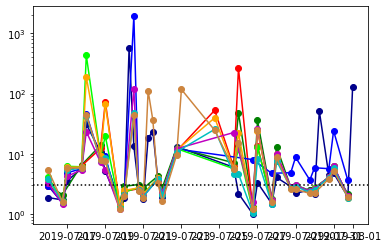

In [38]:
print(r'\begin{table}')
print(r'\begin{center}')
print(r'\caption{\label{table:LBI}}')
print(r'\bgroup')
print(r'\def\arraystretch{1.5}')
print(r'\begin{tabular}{|c|c|}')
print(r'\hline')
print(r'\textbf{WST Dataset} & \textbf{Number of LBI-Predicted WB Breezes} \\')
print(r'\hline')


#        U_kts = wrf_stn_dict[sst_data].vel10.sel(station=stn,datetime=slice(case_start,case_end))*1.94384
#        del_tF = wrf_stn_dict[sst_data].delT_F.sel(station=stn,datetime=slice(case_start,case_end))

U_kts = wrf_stn_dict[sst_data].vel10.mean(dim='station').sel(datetime=slice(case_start,case_end))*1.94384
Cp = 1.003
for ss,sst_data in enumerate(new_plt_order):
    del_tF = wrf_stn_dict[sst_data].delT_F_mean.sel(datetime=slice(case_start,case_end))
    LBI = (U_kts**2)/(Cp*del_tF)
    LBI = LBI.where(LBI>0).dropna(how='any',dim='datetime')
    plt.semilogy(LBI.datetime,LBI,marker='o',c=sst_data_dict[sst_data]['color'])
    if sst_data == 'ERAI': sst_data = 'ERA-I'
    line = r'{} & {} \\'.format(sst_data,len(LBI.where(LBI<=3).dropna(how='any',dim='datetime')))
    print(line)
print(r'\hline')
print(r'\end{tabular}')
print(r'\egroup')
print(r'\end{center}')
print(r'\end{table}')

plt.axhline(3,c='k',ls=':')
plt.show()

# Temperature Difference:

### Averaged over all stations and buoys:

### Calculated for individual stations:

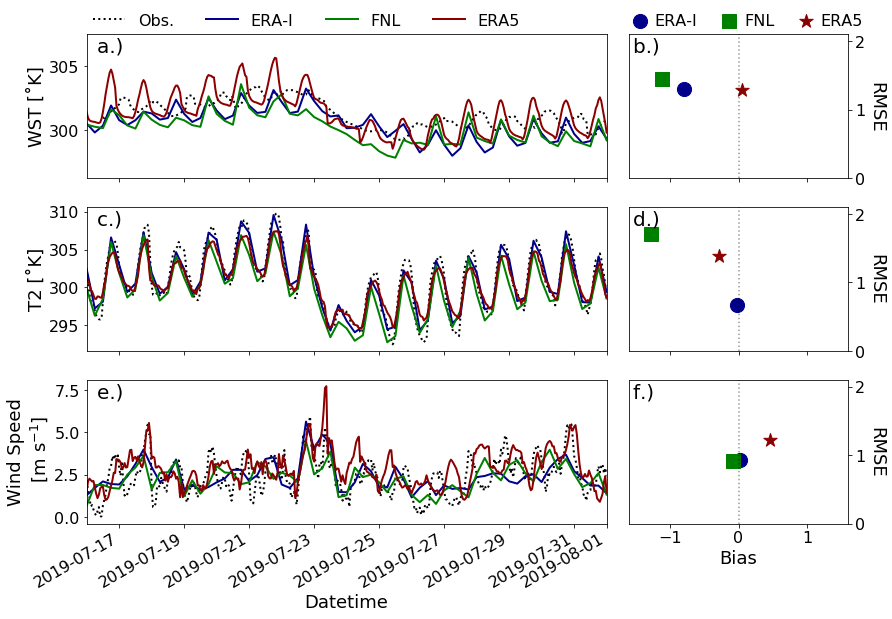

In [27]:
fig = plt.figure(figsize=(14,9))
fig.subplots_adjust(wspace=0.01)

sst_ts = plt.subplot2grid((3, 3), (0, 0), colspan=2)
sst_ts.tick_params(labelbottom=False,labelsize=16)
t2_ts = plt.subplot2grid((3, 3), (1, 0), colspan=2,sharex=sst_ts)
t2_ts.tick_params(labelbottom=False,labelsize=16)
vel_ts = plt.subplot2grid((3, 3), (2, 0), colspan=2,sharex=sst_ts)
vel_ts.tick_params(labelsize=16)

sst_err = plt.subplot2grid((3, 3), (0, 2))
sst_err.tick_params(labelbottom=False,left=False,labelleft=False,right=True,labelright=True,labelsize=16)
t2_err = plt.subplot2grid((3, 3), (1, 2),sharex=sst_err)
t2_err.tick_params(labelbottom=False,left=False,labelleft=False,right=True,labelright=True,labelsize=16)
vel_err = plt.subplot2grid((3, 3), (2, 2),sharex=sst_err)
vel_err.tick_params(left=False,labelleft=False,right=True,labelright=True,labelsize=16)


obs_mean_t2.sel(datetime=slice(case_start,case_end)).plot(ax=t2_ts,c='k',ls=':',lw=2.0,label='Obs.')
obs_mean_sst.sel(datetime=slice(case_start,case_end)).plot(ax=sst_ts,c='k',ls=':',lw=2.0,label='Obs.')
obs_mean_vel.sel(datetime=slice(case_start,case_end)).plot(ax=vel_ts,c='k',ls=':',lw=2.0)

icbc_stats = {}
for cc,icbc in enumerate(icbcs[:]):
    icbc_stats[icbc] = {'t2':{},
                        'sst':{},
                        'vel':{}}
    sample_rate = icbc_dict[icbc]['sample_rate']

    obs_t2 = obs_mean_t2.sel(datetime=slice(case_start,case_end)).resample(datetime=sample_rate).nearest()
    obs_sst = obs_mean_sst.sel(datetime=slice(case_start,case_end)).resample(datetime=sample_rate).nearest()
    obs_vel = obs_mean_vel.sel(datetime=slice(case_start,case_end)).resample(datetime=sample_rate).nearest()

    icbc_col = sst_data_dict[icbc]['color']
        
    sim_t2 = wrf_mean_t2_dict[icbc].sel(datetime=slice(case_start,case_end))
    sim_sst = wrf_mean_sst_dict[icbc].sel(datetime=slice(case_start,case_end))
    sim_vel = wrf_mean_vel_dict[icbc].sel(datetime=slice(case_start,case_end))

    sim_t2.sel(datetime=slice(case_start,case_end)).plot(ax=t2_ts,c=icbc_col,lw=2.0,)
    sim_sst.sel(datetime=slice(case_start,case_end)).plot(ax=sst_ts,c=icbc_col,lw=2.0,label=sst_data_dict[icbc]['name'])
    sim_vel.sel(datetime=slice(case_start,case_end)).plot(ax=vel_ts,c=icbc_col,lw=2.0)

    for vv,var in enumerate(['t2','sst','vel']):
        if var == 't2':
            obs = obs_t2
            sim = sim_t2
        elif var == 'sst':
            obs = obs_sst
            sim = sim_sst
        elif var == 'vel':
            obs = obs_vel
            sim = sim_vel
        var_bias = (sim - obs).mean().data
        var_rmse = (((sim - obs)**2).mean().data)**0.5

        if (np.any(np.isnan(sim))) or (np.any(np.isnan(obs))):
            r2 = np.nan
        else:
            r2,_ = pearsonr(sim, obs)

        icbc_stats[icbc][var]['bias'] = var_bias
        icbc_stats[icbc][var]['rmse'] = var_rmse
        icbc_stats[icbc][var]['corr'] = r2
        
sst_ts.set_xlim(sim_sst.datetime.data[0],sim_sst.datetime.data[-1])
sst_ts.set_ylim(float(obs_sst.min())-3,float(obs_sst.max())+4)
t2_ts.set_ylabel('T2 [˚K]',size=18)
sst_ts.set_ylabel('WST [˚K]',size=18)
vel_ts.set_ylabel('Wind Speed\n [m s$^{-1}$]',size=18)
t2_ts.set_xlabel('',size=18)
sst_ts.set_xlabel('',size=18)
vel_ts.set_xlabel('Datetime',size=18)
sst_ts.legend(frameon=False,fontsize=16,loc=(0.0,1.0),ncol=4)

for vv,var in enumerate(['t2','sst','vel']):
    if var == 't2':
        title_str = 'T2'
        ax = t2_err
    elif var == 'sst':
        title_str = 'WST'
        ax = sst_err
    elif var == 'vel':
        title_str = 'Wind Speed'
        ax = vel_err
    #ax.set_title(title_str,size=22)
    for cc,icbc in enumerate(icbcs):
        mb_point = icbc_stats[icbc][var]['bias']
        mr_point = icbc_stats[icbc][var]['rmse']
        ax.scatter(mb_point,mr_point,
                       c=sst_data_dict[icbc]['color'],
                       label=sst_data_dict[icbc]['name'],
                       marker=sst_data_dict[icbc]['marker'],
                       s=200)
        
    ax.set_xlim(-1.6,1.6)
    ax.set_ylim(0,2.1)
    ax.set_xlabel('')
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('RMSE',size=18,rotation=270,labelpad=20)
    ax.tick_params(labelsize=16)
    ax.axvline(0.0,ls=':',c='k',alpha=0.4)
    ax.set_aspect('equal')
sst_err.legend(frameon=False,fontsize=16,loc=(-0.05,1.0),ncol=3,columnspacing=1.0,handletextpad=-0.1)
vel_err.set_xlabel('Bias',size=18)

sst_ts.text(0.02,0.98,'{}.) '.format(ascii_lowercase[0]),size=20,transform=sst_ts.transAxes,ha='left',va='top')
sst_err.text(0.02,0.98,'{}.) '.format(ascii_lowercase[1]),size=20,transform=sst_err.transAxes,ha='left',va='top')

t2_ts.text(0.02,0.98,'{}.) '.format(ascii_lowercase[2]),size=20,transform=t2_ts.transAxes,ha='left',va='top')
t2_err.text(0.02,0.98,'{}.) '.format(ascii_lowercase[3]),size=20,transform=t2_err.transAxes,ha='left',va='top')

vel_ts.text(0.02,0.98,'{}.) '.format(ascii_lowercase[4]),size=20,transform=vel_ts.transAxes,ha='left',va='top')
vel_err.text(0.02,0.98,'{}.) '.format(ascii_lowercase[5]),size=20,transform=vel_err.transAxes,ha='left',va='top')

if save_figs:
    fig_name = '{}ICBC_Comparison'.format(save_dir)
    plt.savefig('{}.png'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

# Old Spectra Calculation: